# Training Hubmap - HPA - TPU - Noisy EfficientNet B8

Copied from: https://www.kaggle.com/code/markwijkhuizen/hubmap-training-tf-tpu-efficientnet-b7-640x640

# Libraries

In [1]:
# Import EfficientNet models with intermediate endpoints
import sys
sys.path.append('/kaggle/input/efficientnetv2-head-1x1-endpoint-v2/')
sys.path.append('/kaggle/input/efficientnetv2-head-1x1-endpoint-v2/efficientnetv2/')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

import pickle

from kaggle_datasets import KaggleDatasets
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from albumentations import *

import effnetv2_model
import re
import os
import io
import time
import pickle
import math
import random
import sys
import cv2
import gc

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

print(f'tensorflow version: {tf.__version__}')
print(f'tensorflow keras version: {tf.keras.__version__}')
print(f'python version: P{sys.version}')

2022-09-21 17:53:13.384031: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-21 17:53:13.384171: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tensorflow version: 2.4.1
tensorflow keras version: 2.4.0
python version: P3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    IS_TPU = True
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    IS_TPU = False
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}, IS_TPU: {IS_TPU}')

Running on TPU  grpc://10.0.0.2:8470


2022-09-21 17:53:20.684569: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-21 17:53:20.687188: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-21 17:53:20.687224: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-21 17:53:20.687252: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fd964e304477): /proc/driver/nvidia/version does not exist
2022-09-21 17:53:20.689565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS: 8, IS_TPU: True


In [4]:
# Image dimensions
#IMG_SIZE_FULL = 640
#IMG_SIZE = 640
IMG_SIZE_FULL = 768
IMG_SIZE = 768

In [5]:
# For TPU's the dataset needs to be stored in Google Cloud
# Retrieve the Google Cloud location of the dataset

DATASET_SIZE_NAME = 'ds-bojack-hubmap-hpa-tfrecords-768' if IMG_SIZE == 768 else 'hubmap-patched-tfrecords-300x300'
print("[DATASET_SIZE_NAME] DATASET_SIZE_NAME", DATASET_SIZE_NAME)
#GCS_DS_PATH = KaggleDatasets().get_gcs_path('hubmap-patched-tfrecords-300x300')
GCS_DS_PATH = KaggleDatasets().get_gcs_path(DATASET_SIZE_NAME)

[DATASET_SIZE_NAME] DATASET_SIZE_NAME ds-bojack-hubmap-hpa-tfrecords-768


In [6]:
SEED = 43
DEBUG = False

# Image dimensions
#IMG_SIZE_FULL = 640
#IMG_SIZE = 640

N_PATCHES_PER_IMAGE = (IMG_SIZE_FULL // IMG_SIZE) ** 2
N_CHANNELS = 3
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

print(f"PATCHES: {N_PATCHES_PER_IMAGE}, INPUT_SHAPE={INPUT_SHAPE}")

# EfficientNet version, b0/b1/b2/b3/b4/b5/b6/b7/b8
EFN_SIZE = 'b8'
# Peak Learning Rate
LR_MAX_WHOLE = 8e-4
N_FOLDS = 4
TRAIN_FOLDS = [0]

# Epochs are run 10 at a time due to low training samples
COMBINE_EPOCHS = 4
EPOCHS_WHOLE = 200 // COMBINE_EPOCHS

# Batch size
BATCH_SIZE = 4 * REPLICAS

# Dataset Mean and Standard Deviation
#MEAN = np.load('/kaggle/input/hubmap-patched-tfrecords-300x300/MEAN.npy')
#STD = np.load('/kaggle/input/hubmap-patched-tfrecords-300x300/STD.npy')
MEAN = np.load(f'/kaggle/input/{DATASET_SIZE_NAME}/MEAN.npy')
STD = np.load(f'/kaggle/input/{DATASET_SIZE_NAME}/STD.npy')


# Tensorflow AUTO flag
AUTO = tf.data.experimental.AUTOTUNE
if TPU:
    NUM_PARALLEL_CALLS = AUTO
else:
    NUM_PARALLEL_CALLS = cpu_count()

print(f'BATCH_SIZE: {BATCH_SIZE}, NUM_PARALLEL_CALLS: {NUM_PARALLEL_CALLS}')

PATCHES: 1, INPUT_SHAPE=(768, 768, 3)
BATCH_SIZE: 32, NUM_PARALLEL_CALLS: -1


In [7]:
print(f'MEAN: {MEAN}, STD: {STD}')

MEAN: [0.16183166 0.18965797 0.16978174], STD: [0.16973363 0.19511822 0.17539316]


In [8]:
# Result Directories
FOLDS_DIR="/kaggle/working/folds"
CHECKPOINTS_DIR="/kaggle/working/checkpoints"
PREDICTIONS_DIR="/kaggle/working/predictions"
FOLD_FILE_PATH=os.path.join(FOLDS_DIR, F"dict_indxs_fold{N_FOLDS}.pickle")

os.makedirs(FOLDS_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Copy Trained Models to Working

In [9]:
TRAINED_MODELS_DIR = "../input/hubmap-train-tf-tpu-efficientnet-b8-folds"

if os.path.exists(TRAINED_MODELS_DIR):
    print("[COPY] COPYING TRAINED MODELS...")
    !cp -r "{TRAINED_MODELS_DIR}"/* "/kaggle/working"
    
        

[COPY] COPYING TRAINED MODELS...


In [10]:
# Folds
!ls -lh "{FOLDS_DIR}"

# Predictions
!ls -lh "{PREDICTIONS_DIR}"

# Checkpoints
for fold in range(N_FOLDS):
    !ls -lh "{CHECKPOINTS_DIR}/fold{fold}"

total 12K
-rw-r--r-- 1 root root 12K Sep 21 17:54 dict_indxs_fold4.pickle
total 724K
-rw-r--r-- 1 root root  805 Sep 21 17:54 best_predictions.pickle
-rw-r--r-- 1 root root 179K Sep 21 17:54 metrics_fold0.pickle
-rw-r--r-- 1 root root 179K Sep 21 17:54 metrics_fold1.pickle
-rw-r--r-- 1 root root 179K Sep 21 17:54 metrics_fold2.pickle
-rw-r--r-- 1 root root 179K Sep 21 17:54 metrics_fold3.pickle
total 780M
-rw-r--r-- 1 root root 390M Sep 21 17:53 best_model_0.h5
-rw-r--r-- 1 root root 4.0K Sep 21 17:53 history_fold0.csv
-rw-r--r-- 1 root root 390M Sep 21 17:53 model_0.h5
total 780M
-rw-r--r-- 1 root root 390M Sep 21 17:53 best_model_1.h5
-rw-r--r-- 1 root root 3.7K Sep 21 17:53 history_fold1.csv
-rw-r--r-- 1 root root 390M Sep 21 17:53 model_1.h5
total 780M
-rw-r--r-- 1 root root 390M Sep 21 17:53 best_model_2.h5
-rw-r--r-- 1 root root 3.5K Sep 21 17:53 history_fold2.csv
-rw-r--r-- 1 root root 390M Sep 21 17:53 model_2.h5
total 780M
-rw-r--r-- 1 root root 390M Sep 21 17:53 best_model_3.

# Seed

In [11]:
# Seed all random number generators
def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    

seed_everything()

# Train

In [12]:
# Train DataFrame
train = pd.read_csv('/kaggle/input/hubmap-organ-segmentation/train.csv')
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

# Add Ordinal Encoded Organ
train['organ_ordinal'] = train['organ'].astype('category').cat.codes
N_ORGANS = train['organ'].nunique()
ORGANS = sorted(train['organ'].unique())
org_ord2org = dict(enumerate(train['organ'].astype('category').cat.categories))
print(f'N_ORGANS: {N_ORGANS}, ORGANS: {ORGANS}')

display(train.head())
display(train.info())

N_SAMPLES: 351
N_ORGANS: 5, ORGANS: ['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']


id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  organ_ordinal  
0    Male              3  
1    Male              3  
2    Male              4  
3    Male              2  
4  Female              4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
 10  organ_ordinal     351 non-null    int8   
dtypes: float64(2), int64(4), int8(1), object(4)
memory usage: 27.9+ KB


None

In [13]:
len(train[train['organ'] == 'lung'])

48

# Utility Functions

In [14]:
# One in K chance function
def tf_rand_int(minval, maxval, dtype=tf.int64):
    minval = tf.cast(minval, dtype)
    maxval = tf.cast(maxval, dtype)
    return tf.random.uniform(shape=(), minval=minval, maxval=maxval, dtype=dtype)

def one_in(k):
    return 0 == tf_rand_int(0, k)

# Loss

The following code provides a wide variety of semantic segmentations losses and metrics. Surprisingly, dice loss did perform worse than good old binary crossnetropy. The only code used in this notebook is the IoU metric.

In [15]:
# Source: https://github.com/shruti-jadon/Semantic-Segmentation-Loss-Functions/blob/master/loss_functions.py
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1
threshold=0.50

class Semantic_loss_functions(object):
    def __init__(self):
        print ('semantic loss functions initialized')
        
    def iou(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.where(y_pred > threshold, x=1.0, y=0.0)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f + y_pred_f) - intersection
        return intersection / (union + epsilon)

    def dice_coef(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f, axis=1)
        return (2. * intersection + K.epsilon()) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

    def sensitivity(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def specificity(self, y_true, y_pred):
        true_negatives = K.sum(
            K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())

    def convert_to_logits(self, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))

    def weighted_cross_entropyloss(self, y_true, y_pred):
        y_pred = self.convert_to_logits(y_pred)
        pos_weight = beta / (1 - beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred,
                                                        targets=y_true,
                                                        pos_weight=pos_weight)
        return tf.reduce_mean(loss)

    def focal_loss_with_logits(self, logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(
            -logits)) * (weight_a + weight_b) + logits * weight_b

    def focal_loss(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        logits = tf.math.log(y_pred / (1 - y_pred))

        loss = self.focal_loss_with_logits(logits=logits, targets=y_true,
                                      alpha=alpha, gamma=gamma, y_pred=y_pred)

        return tf.reduce_mean(loss)

    def depth_softmax(self, matrix):
        sigmoid = lambda x: 1 / (1 + K.exp(-x))
        sigmoided_matrix = sigmoid(matrix)
        softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
        return softmax_matrix

    def generalized_dice_coefficient(self, y_true, y_pred):
        smooth = 1e0
        y_true = tf.cast(y_true, tf.float32)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
    def dice_loss(self, y_true, y_pred):
        loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
        return loss
    
    def dice_loss_symmetric(self, y_true, y_pred):
        loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
        loss_neg = 1 - self.generalized_dice_coefficient(1 - y_true, 1 - y_pred)
        return 0.50 * (loss + loss_neg)

    def bce_dice_loss(self, y_true, y_pred):
        loss = binary_crossentropy(y_true, y_pred) + \
               self.dice_loss(y_true, y_pred)
        return loss / 2.0

    def confusion(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.clip(y_pred, 0, 1)
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.clip(y_true, 0, 1)
        y_neg = 1 - y_pos
        tp = K.sum(y_pos * y_pred_pos)
        fp = K.sum(y_neg * y_pred_pos)
        fn = K.sum(y_pos * y_pred_neg)
        prec = (tp + smooth) / (tp + fp + smooth)
        recall = (tp + smooth) / (tp + fn + smooth)
        return prec, recall

    def true_positive(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pos = K.round(K.clip(y_true, 0, 1))
        tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
        return tp

    def true_negative(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
        return tn

    def tversky_index(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        alpha = 0.75
        return (true_pos + smooth) / (true_pos + alpha * false_neg + (
                    1 - alpha) * false_pos + smooth)

    def tversky_loss(self, y_true, y_pred):
        return 1 - self.tversky_index(y_true, y_pred)

    def focal_tversky(self, y_true, y_pred, gamme=2.0):
        pt_1 = self.tversky_index(y_true, y_pred)
        return K.pow((1 - pt_1), gamma)

    def log_cosh_dice_loss(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        x = self.dice_loss(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

In [16]:
SEMANTIC_LOSS_FUNCTIONS = Semantic_loss_functions()

semantic loss functions initialized


# Feature Pyramid Network (FPN)

(Pytorch Source)[https://www.kaggle.com/code/thedevastator/training-fastai-baseline#Model}

In [17]:
def FPN(xs, output_channels, last_layer, debug=False):
    def _conv(x):
        x = tf.keras.layers.ZeroPadding2D(padding=1)(x)
        x = tf.keras.layers.Conv2D(output_channels * 2, 3, padding='SAME', kernel_initializer='he_normal', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ZeroPadding2D(padding=1)(x)
        x = tf.keras.layers.Conv2D(output_channels, 3, padding='SAME', kernel_initializer='he_normal')(x)
        x = tf.image.resize(x, size=target_size, method=tf.image.ResizeMethod.BILINEAR)
        x = tf.nn.relu(x)
        return x

    target_size = last_layer.shape[1:3]
    xs = tf.keras.layers.Concatenate()([_conv(x) for x in xs])
    x = tf.keras.layers.Concatenate()([xs, last_layer])

    if debug:
        return x, xs
    else:
        return x

# Atrous Spatial Pyramid Pooling (ASPP)

(Pytorch Source)[https://www.kaggle.com/code/thedevastator/training-fastai-baseline#Model]

In [18]:
def ASPP(x, mid_c=320, dilations=[1, 2, 3, 4], out_c=640, debug=False):
    def _aspp_module(x, filters, kernel_size, padding, dilation, groups=1):
        x = tf.keras.layers.ZeroPadding2D(padding=padding)(x)
        x = tf.keras.layers.Conv2D(
                filters=filters,
                kernel_size=kernel_size,
                dilation_rate=dilation,
                groups=1 if IS_TPU else groups,
                kernel_initializer='he_uniform',
            )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.nn.relu(x)
        
        return x
    
    x0 = tf.math.reduce_max(x, axis=(1,2), keepdims=True)
    x0 = tf.keras.layers.Conv2D(filters=mid_c, kernel_size=1, strides=1, kernel_initializer='he_uniform', use_bias=False)(x0)
    x0 = tf.keras.layers.BatchNormalization(gamma_initializer=tf.constant_initializer(value=0.25))(x0)
    x0 = tf.nn.relu(x0)
                                  
                                  
    xs = (
        [_aspp_module(x, mid_c, 1, padding=0, dilation=1)] +
        [_aspp_module(x, mid_c, 3, padding=d, dilation=d, groups=4) for d in dilations]
    )
    
    x0= tf.image.resize(x0, size=xs[0].shape[1:3])
    x = tf.keras.layers.Concatenate()([x0] + xs)
    x = tf.keras.layers.Conv2D(filters=out_c, kernel_size=1, kernel_initializer='he_uniform', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
                       
    if debug:
        return x, x0, xs
    else:
        return x

# Upsample

In [19]:
# PixelShuffle implemented in Tensorflow, not used
def PixelShuffle(x, upscale_factor=2):
    _, w, h, c = x.shape
    n = -1

    c_out = c // upscale_factor ** 2
    w_out = w * upscale_factor
    h_out = h * upscale_factor

    x = tf.reshape(x, [-1, upscale_factor, upscale_factor, w, h, c_out])
    x = tf.transpose(x, [0, 3, 1, 4, 2, 5])
    x = tf.reshape(x, [-1, w_out, h_out, c_out])

    return x

In [20]:
# Inspiration: https://www.tensorflow.org/tutorials/generative/pix2pix#build_an_input_pipeline_with_tfdata
def upsample(x, concat, target_filters, name, conv2dt_kernel_init_max, relu=True, dropout=0, debug=False):
    filters = concat.shape[-1]
    x_up = tf.keras.layers.Conv2DTranspose(
            filters, # Number of Convolutional Filters
            kernel_size=4, # Kernel Size
            strides=2, # Kernel Steps
            padding='SAME', # linear scaling
            name=f'Conv2DTranspose_{name}', # Name of Layer
            kernel_initializer='he_uniform',
            use_bias=False,
        )(x)
    
    concat = tf.keras.layers.BatchNormalization(
        gamma_initializer=tf.constant_initializer(value=0.25),
        name=f'BatchNormalization_{name}'
    )(concat)
    x = tf.keras.layers.Concatenate(name=f'Concatenate_{name}')([x_up, concat])
    x = tf.nn.relu(x)
    
        
    x = tf.keras.layers.Conv2D(target_filters, 3, padding='SAME', kernel_initializer='he_uniform', activation='relu', name=f'Conv2D_1_{name}')(x)
    x = tf.keras.layers.Conv2D(target_filters, 3, padding='SAME', kernel_initializer='he_uniform', name=f'Conv2D_2_{name}')(x)
    
    if relu:
        x = tf.nn.relu(x)
    
    x = tf.keras.layers.Dropout(dropout, name=f'Dropout_{name}')(x)

    if debug:
        return x, x_up, concat
    else:
        return x

# Model

A lot of debug code is present in the model construction, which will be later used to show the values during a forward pass. 

In [21]:
GCS_WEIGHTS_PATH = KaggleDatasets().get_gcs_path('efficientnetv2-head-1x1-endpoint-v2')

In [22]:
def get_model(dropout_decoder=0, dropout_cnn=0, file_path=None, lr=1e-3, eps=1e-7, clipnorm=5.0, wd_coef=1e-2, cnn_trainable=True, enable_TPU=IS_TPU, debug=DEBUG):
    # enable XLA optmizations
    tf.config.optimizer.set_jit(True)
    # Set seed for deterministic weights initialization
    seed_everything()
    
    with strategy.scope():
        # EfficientNetV2 Backbone # 
        cnn = effnetv2_model.get_model(f'efficientnet-{EFN_SIZE}', include_top=False, weights=None if IS_TPU else 'jft', model_config={ 'conv_dropout': dropout_cnn })
        if enable_TPU:
            print("ENABLED TPU")
            WEIGHT_PATH = f'{GCS_WEIGHTS_PATH}/noisy_student_efficientnet-{EFN_SIZE}'
            ckpt = tf.train.latest_checkpoint(WEIGHT_PATH)
            cnn.load_weights(ckpt)

        # Inputs, note the names are equal to the dictionary keys in the dataset
        image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.float32)
        image_norm = tf.cast(image, tf.float32) / 255
        image_norm = tf.keras.layers.experimental.preprocessing.Normalization(mean=MEAN, variance=STD, dtype=tf.float32)(image_norm)

        embedding, up6, up5, up4, up3, up2, up1 = cnn(image_norm, with_endpoints=True)
        
        if debug:
            print(f'embedding shape: {embedding.shape} up1 shape: {up1.shape}, up2 shape: {up2.shape}')
            print(f'up3 shape: {up3.shape}, up4 shape: {up4.shape}, up5 shape: {up5.shape}, up6 shape: {up6.shape}')
                
        if debug:
            dec0, x0, (xs0, xs1, xs2, xs3, xs4) = ASPP(up2, debug=True)
        else:
            dec0 = ASPP(up2)
        
        dec0 = tf.keras.layers.Dropout(0.30)(dec0)

        if debug:
            dec1, dec1_up, dec1_concat = upsample(dec0, up3, up4.shape[-1] * 4, 'upsample1', 0.02, dropout=dropout_decoder, debug=True)
            dec2, dec2_up, dec2_concat = upsample(dec1, up4, up5.shape[-1] * 2, 'upsample2', 0.02, dropout=dropout_decoder, debug=True)
            dec3, dec3_up, dec3_concat = upsample(dec2, up5, up6.shape[-1] * 2, 'upsample3', 0.02, debug=True)
            dec4, dec4_up, dec4_concat = upsample(dec3, up6, 32, 'upsample4', 0.02, debug=True)
        else:
            dec1 = upsample(dec0, up3, up4.shape[-1] * 4, 'upsample1', 0.02, dropout=dropout_decoder)
            dec2 = upsample(dec1, up4, up5.shape[-1] * 2, 'upsample2', 0.02, dropout=dropout_decoder)
            dec3 = upsample(dec2, up5, up6.shape[-1] * 2, 'upsample3', 0.02)
            dec4 = upsample(dec3, up6, 64, 'upsample4', 0.02)
        
        if debug:
            dec_fpn, dec_fpn_xs = FPN([dec0, dec1, dec2, dec3], 32, dec4, debug=True)
        else:
            dec_fpn = FPN([dec0, dec1, dec2, dec3], 32, dec4)
        
        if debug:
            print(f'dec0 shape: {dec0.shape}, dec1 shape: {dec1.shape}, dec2 shape: {dec2.shape}, dec3 shape: {dec3.shape}, dec4 shape: {dec4.shape}')
            print(f'dec_fpn shape: {dec_fpn.shape}')

        # Head
        x = tf.keras.layers.Dropout(0.10)(dec_fpn)
        x = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=1,
            padding='SAME',
            kernel_initializer=tf.random_normal_initializer(0.00, 0.05),
            activation=None if debug else 'sigmoid',
            name='Conv2D_3_head'
        )(x)
        output = tf.image.resize(x, size=[IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.BILINEAR)

        # We will use the famous Adam optimizer for fast learning
        optimizer = tf.optimizers.Adam(learning_rate=lr, epsilon=eps, clipnorm=clipnorm)

        # Loss
        loss = tf.keras.losses.BinaryCrossentropy()
        
        # Metrics
        metrics = [
            SEMANTIC_LOSS_FUNCTIONS.iou,
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.BinaryAccuracy(),
        ]

        if debug:
            model = tf.keras.models.Model(inputs=image, outputs=[
                image_norm,
                embedding, up6, up5, up4, up3, up2, up1,
                dec0, x0, xs0, xs1, xs2, xs3, xs4,
                dec1, dec1_up, dec1_concat,
                dec2, dec2_up, dec2_concat,
                dec3, dec3_up, dec3_concat,
                dec4, dec4_up, dec4_concat,
                dec_fpn, dec_fpn_xs, output
                
            ])
        else:
            model = tf.keras.models.Model(inputs=image, outputs=[output])
        
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        if file_path:
            print('Loading pretrained weights...')
            model.load_weights(file_path)

        return model

In [23]:
# Pretrained File Path: '/kaggle/input/sartorius-training-dataset/model.h5'
tf.keras.backend.clear_session()
gc.collect()
    
model = get_model(file_path=None, debug=False)

ENABLED TPU


2022-09-21 17:56:37.846567: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-21 17:56:37.984437: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-21 17:56:38.122438: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-21 17:56:38.203728: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-21 17:56:38.275287: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [24]:
# Plot model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 768, 768, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 768, 768, 3)  0           tf.cast[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 768, 768, 3)  7           tf.math.truediv[0][0]            
______________________________________________________________________________________________

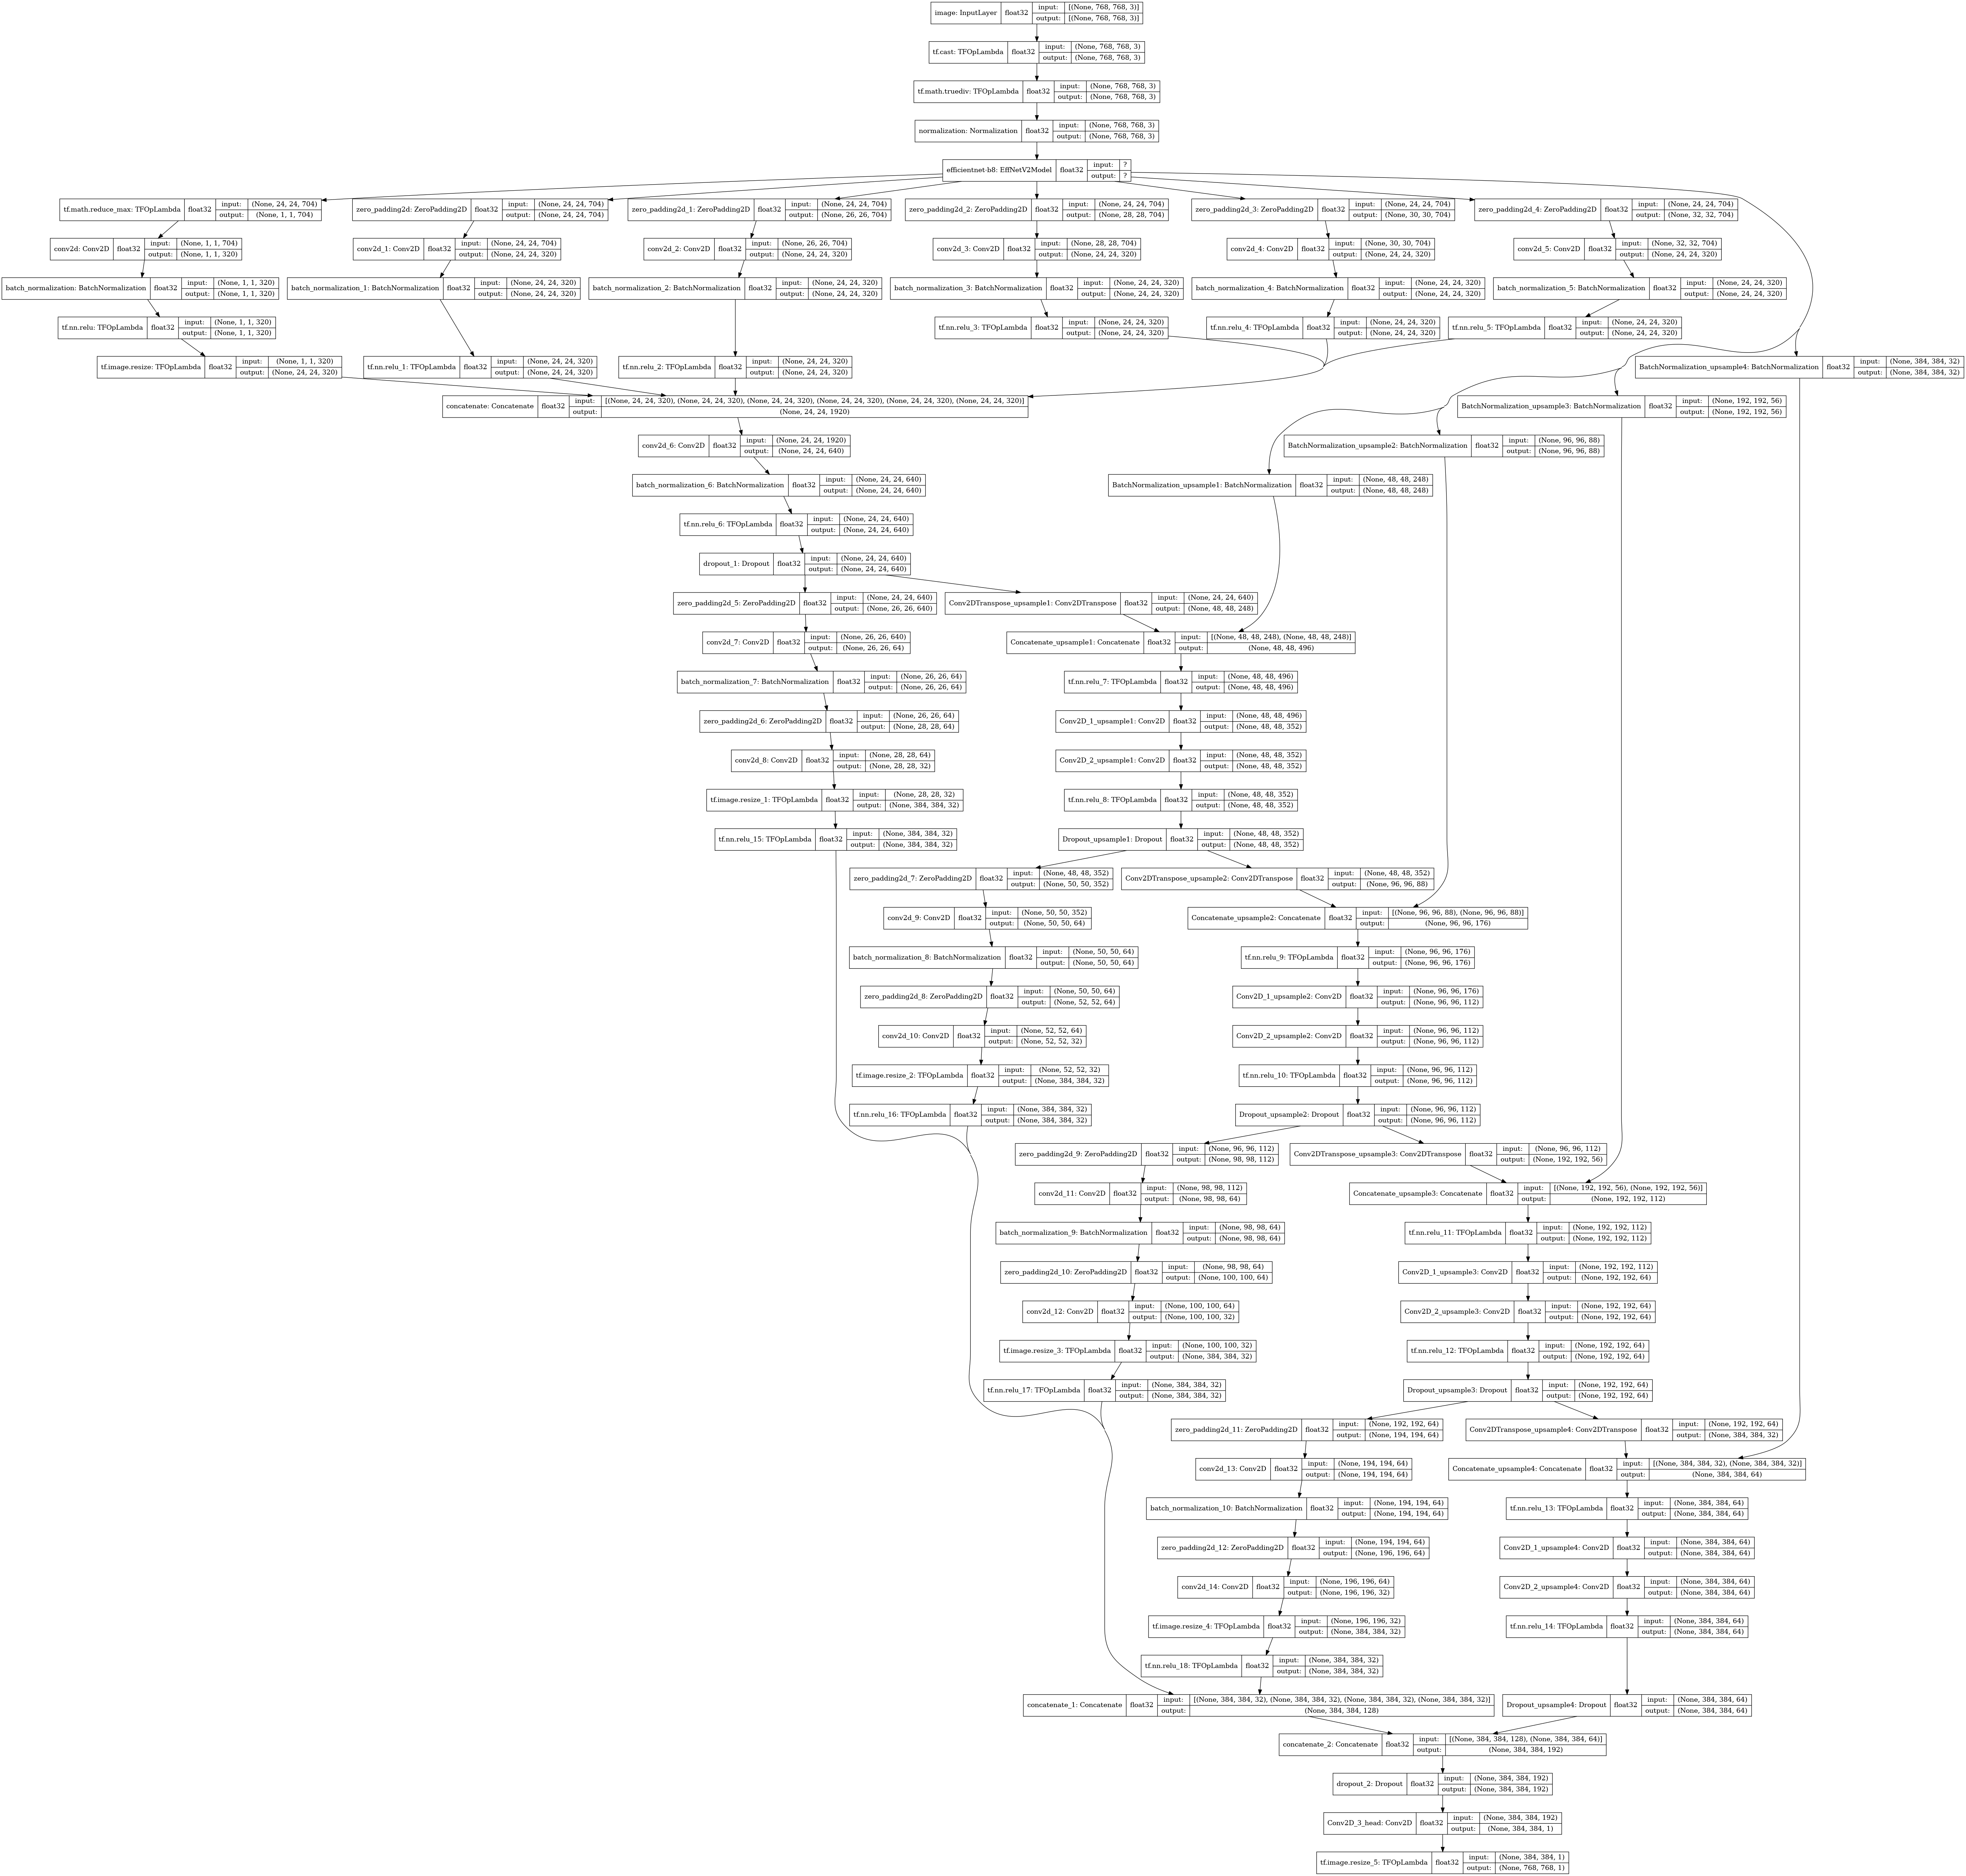

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True)

# Augmentations

Since the train set is different from the train set heavy augmentations are required to make the model generalize well.

# Dataset

In [26]:
# Function to benchmark the dataset
def benchmark_dataset(dataset, num_epochs=3, n_steps_per_epoch=10, bs=BATCH_SIZE):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for idx, (images, labels) in enumerate(dataset.take(n_steps_per_epoch + 1)):
            if idx == 0:
                epoch_start = time.perf_counter()
            elif idx == 1 and epoch_num == 0:
                print(f'image shape: {images.shape}, image dtype: {images.dtype}')
            else:
                pass
        epoch_t = time.perf_counter() - epoch_start
        mean_step_t = round(epoch_t / n_steps_per_epoch * 1000, 1)
        n_imgs_per_s = int(1 / (mean_step_t / 1000) * bs)
        print(f'epoch {epoch_num} took: {round(epoch_t, 2)} sec, mean step duration: {mean_step_t}ms, images/s: {n_imgs_per_s}')

In [27]:
# Plots a batch of images
def show_batch(dataset, rows=4, cols=4):
    imgs, lbls = next(iter(dataset))
    imgs = imgs.numpy()
    # Plot
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(rows*4, cols*4))
    for r in range(rows):
        for c in range(cols // 2):
            img = imgs[r*cols+c]
            axes[r, c*2].imshow(img)
            axes[r, c*2].set_title(f'std: {img.std():.1f}')
            lbl = lbls[r*cols+c]
            axes[r, c*2+1].imshow(lbl)

In [28]:
# Decodes the TFRecords
def decode_image(record_bytes, val):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'organ': tf.io.FixedLenFeature([], tf.string),
    })

    image = tf.io.parse_tensor(features['image'], out_type=tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, N_CHANNELS])
       
    mask = tf.io.parse_tensor(features['mask'], out_type=tf.uint8)
    mask = tf.reshape(mask, [IMG_SIZE, IMG_SIZE, 1])
    
    # Ogran
    organ = features['organ']
    
    return image, mask, organ

In [29]:
def augment_image(image, mask, organ, val, return_organ):
    
    if not val:
        rotations = tf_rand_int(0, 4, dtype=tf.int32)

        image = tf.image.rot90(image, rotations)
        mask = tf.image.rot90(mask, rotations)
        
        if one_in(2):
            image = tf.image.transpose(image)
            mask = tf.image.transpose(mask)
        
        # Pixel Level Augmentations
        if one_in(2):
            image = tf.image.random_hue(image, 0.2)
        if one_in(2):
            image = tf.image.random_saturation(image, 0.80, 1.20)
        if one_in(2):
            image = tf.image.random_contrast(image, 0.80, 1.20)
        if one_in(2):
            image = tf.image.random_brightness(image, 0.10)
        if one_in(2):
            image = tf.image.random_jpeg_quality(image, 75, 100)
        
        # Random Crop
        offset_x = tf.random.uniform([], 0, tf.cast(IMG_SIZE * 0.50, tf.int32), dtype=tf.int32)
        img_size_crop = IMG_SIZE - offset_x
        if offset_x > 0:
            offset_y = tf.random.uniform([], 0, offset_x, dtype=tf.int32)
        else:
            offset_y = tf.constant(0, dtype=tf.int32)

        # Crop
        if one_in(2):
            image = tf.slice(image, [offset_x, offset_y, 0], [img_size_crop, img_size_crop, N_CHANNELS])
            mask = tf.slice(mask, [offset_x, offset_y, 0], [img_size_crop, img_size_crop, 1])
            
            image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.BICUBIC)
            image = tf.cast(image / tf.reduce_max(image) * 255, tf.uint8)
            
            mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        # Rotate
        if one_in(2):
            angle = tf.random.uniform([], -45 * math.pi / 180, 45 * math.pi / 180, dtype=tf.float32)
            image = tfa.image.rotate(image, angle, interpolation='bilinear', fill_mode='reflect')
            mask = tfa.image.rotate(mask, angle, interpolation='nearest', fill_mode='reflect')
        
        # Resize
        image = tf.cast(image / tf.reduce_max(image) * 255, tf.uint8)
        
        # Explicit Reshape for TPU
        image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, N_CHANNELS])
        mask = tf.reshape(mask, [IMG_SIZE, IMG_SIZE, 1])

    if return_organ:
        return image, mask, organ
    else:
        return image, mask

In [30]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [31]:
#GCS_DS_PATH = KaggleDatasets().get_gcs_path('hubmap-patched-tfrecords-300x300')
#GCS_DS_PATH = KaggleDatasets().get_gcs_path(DATASET_SIZE_NAME)
print(f'GCS_DS_PATH: {GCS_DS_PATH}')

TFRECORDS_FILE_PATHS = np.array(tf.io.gfile.glob(f'{GCS_DS_PATH}/*.tfrecords'))
TFRECORDS_FILE_PATHS = np.array(
    sorted(TFRECORDS_FILE_PATHS, key=lambda fp: int(fp.split('.')[-2].split('_')[-1]))
)
print(f'Found {len(TFRECORDS_FILE_PATHS)} TFRecords')

GCS_DS_PATH: gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0
Found 351 TFRecords


In [32]:
N_SAMPLES_PER_TFRECORD = np.load(f'/kaggle/input/{DATASET_SIZE_NAME}/N_SAMPLES_PER_TFRECORD.npy')
print(f'N_SAMPLES_PER_TFRECORD shape: {N_SAMPLES_PER_TFRECORD.shape}, dtype: {N_SAMPLES_PER_TFRECORD.dtype}')

N_SAMPLES_PER_TFRECORD shape: (351,), dtype: int16


In [33]:
# Check whether file paths are correctly ordered
pd.options.display.max_colwidth = 999
display(pd.DataFrame(TFRECORDS_FILE_PATHS, columns=['File Path']).sample(10, random_state=SEED))

File Path
82    gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0/batch_82.tfrecords
233  gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0/batch_233.tfrecords
183  gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0/batch_183.tfrecords
226  gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0/batch_226.tfrecords
205  gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0/batch_205.tfrecords
38    gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0/batch_38.tfrecords
221  gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0/batch_221.tfrecords
167  gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0/batch_167.tfrecords
315  gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0/batch_315.tfrecords
281  gs://kds-30133869ad7935adf74d391a28d8997db04ed568556a3a614a06a1a0/batch_281.tfrecords

In [34]:
def get_dataset(tfrecord_idxs=None, bs=BATCH_SIZE, idxs=None, return_steps=False, val=False, return_organ=False, debug=False):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    if IS_TPU:
        npr = 1 if val else AUTO
    else:
        npr = 1 if val else cpu_count()
    
    if tfrecord_idxs is None:
        dataset = tf.data.TFRecordDataset(TFRECORDS_FILE_PATHS, num_parallel_reads=npr)
    else:
        dataset = tf.data.TFRecordDataset(TFRECORDS_FILE_PATHS[tfrecord_idxs], num_parallel_reads=npr)
    
    dataset = dataset.map(
        lambda record_bytes: decode_image(record_bytes, val), num_parallel_calls=AUTO if IS_TPU else 1
    )
    
    # Cache dataset to speedup dataloader
    if not debug:
        dataset = dataset.cache()
    
    if not val and not debug:
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.shuffle(128)
        dataset = dataset.repeat()
    
    # Augment
    dataset = dataset.map(
        lambda image, mask, organ: augment_image(image, mask, organ, val, return_organ), num_parallel_calls=npr
    )

    dataset = dataset.batch(bs, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    
    if return_steps:
        return dataset, math.ceil(N_SAMPLES_PER_TFRECORD[tfrecord_idxs].sum() / bs)
    else:
        return dataset

In [35]:
# Benchmark Dataset
benchmark_dataset(get_dataset(debug=True))

image shape: (32, 768, 768, 3), image dtype: <dtype: 'uint8'>
epoch 0 took: 13.37 sec, mean step duration: 1336.7ms, images/s: 23


2022-09-21 17:57:29.941041: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 50278, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1663783049.937690325","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 50278, Output num: 0","grpc_status":3}


epoch 1 took: 7.66 sec, mean step duration: 765.7ms, images/s: 41
epoch 2 took: 7.47 sec, mean step duration: 747.2ms, images/s: 42


In [36]:
# Sanity check
images, labels = next(iter(get_dataset(debug=True)))
print(f'images shape: {images.shape}, labels shape: {labels.shape}')
print(f'images dtype: {images.dtype}, labels dtype: {labels.dtype}')

percentiles = [0.01, 0.05, 0.10, 0.25, 0.40 ,0.50, 0.60, 0.75, 0.90, 0.95, 0.99]
display(pd.Series(images.numpy().flatten()).describe(percentiles=percentiles).to_frame(name='images').T)
display(pd.Series(labels.numpy().flatten()).value_counts().to_frame(name='labels').T)

images shape: (32, 768, 768, 3), labels shape: (32, 768, 768, 1)
images dtype: <dtype: 'uint8'>, labels dtype: <dtype: 'uint8'>


count       mean        std  min   1%   5%  10%  25%   40%   50%  \
images  56623104.0  52.814078  54.934345  0.0  0.0  0.0  0.0  3.0  16.0  30.0   

         60%   75%    90%    95%    99%    max  
images  56.0  94.0  137.0  158.0  192.0  255.0

0        1
labels  16465176  2409192

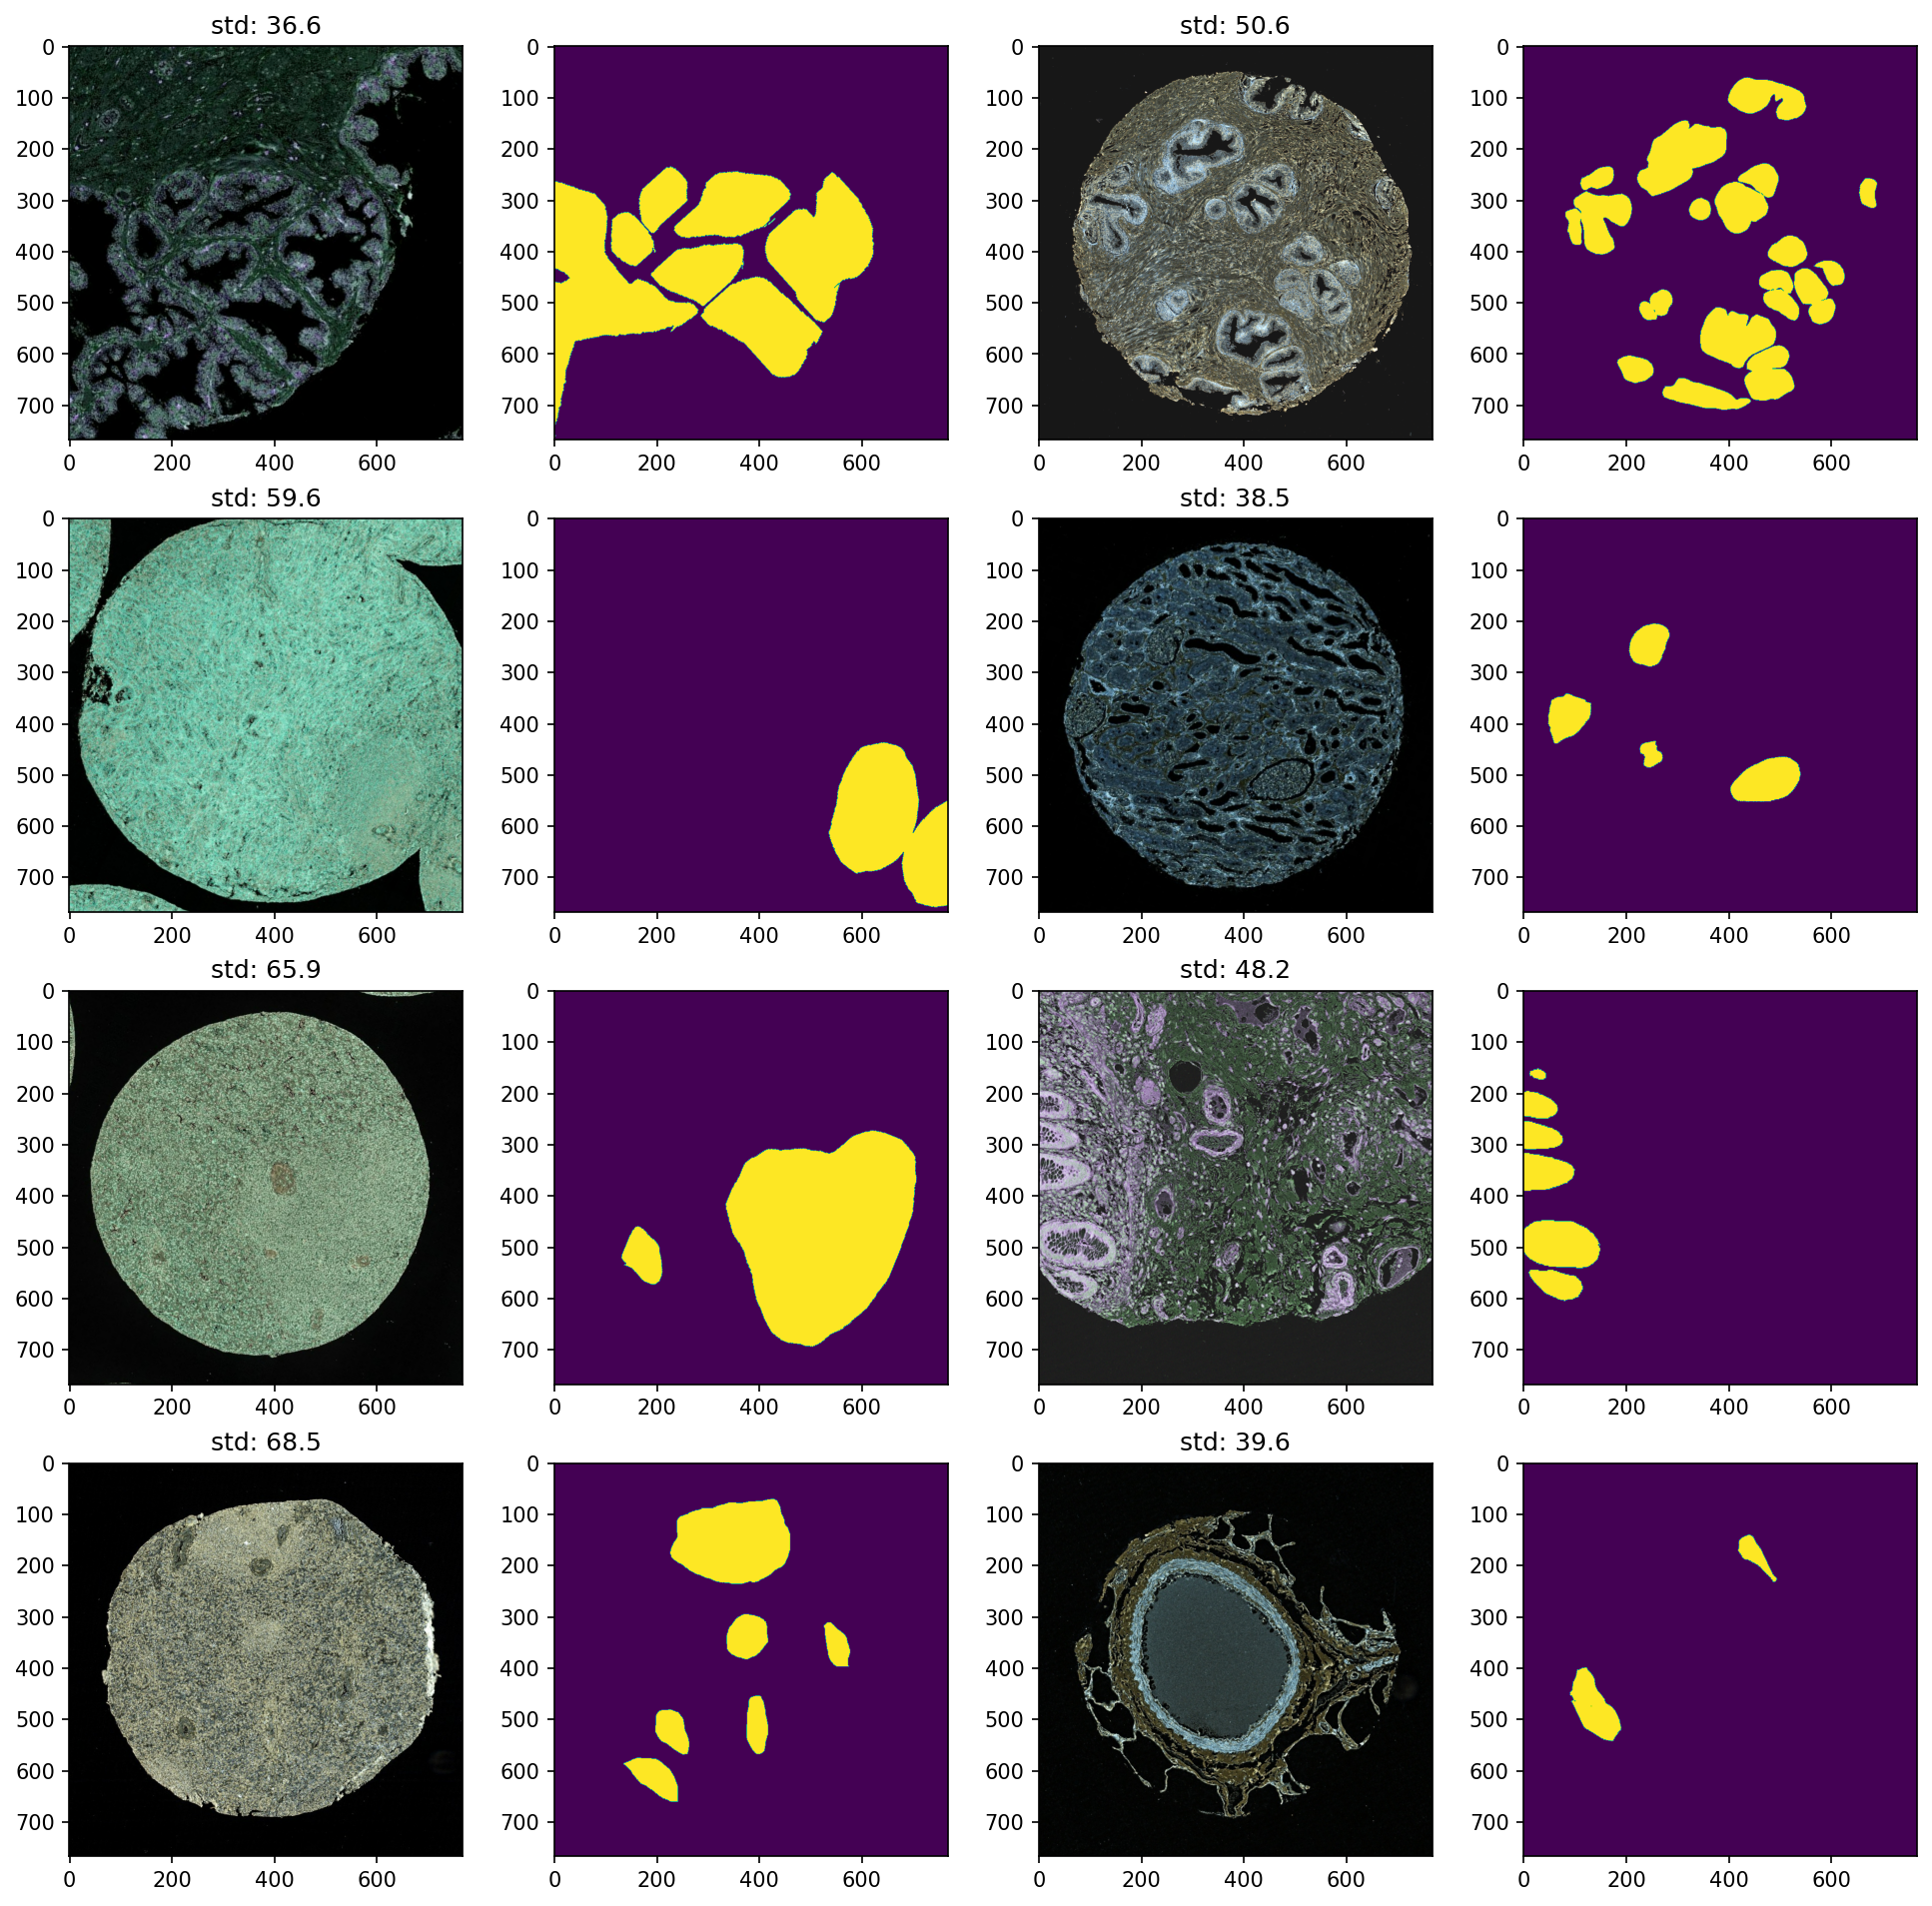

In [37]:
# Show what we will be training on
show_batch(get_dataset(bs=16, debug=True))

# Weights Initialization

The following function shows the intermediate values during a forward pass. It is important for values to not explode (become huge) or vanish (become tiny), as this will affect the gradient update by having too large or too small updates. Moreover, many values are concatenated in a UNet architecture, those values should have equal distributions, otherwise consecutive layers will only pay attention to a single part of the input. Lastly, the output sigmoid function should be initialized to be centered around 0.50 to start with large gradients. If all values are near 0 or near 1 at the start gradients will be tiny as the slope of the sigmoid function is near straight at 0 or 1.

It is a lot of work to get statistics on all intermediate values and plot the output, however it gives you a good understanding of how a neural network behaves, and, more importantly, why it could not behave the way you expect it to do.

images shape: (8, 768, 768, 3)
ENABLED TPU
embedding shape: (None, 2816) up1 shape: (None, 24, 24, 2816), up2 shape: (None, 24, 24, 704)
up3 shape: (None, 48, 48, 248), up4 shape: (None, 96, 96, 88), up5 shape: (None, 192, 192, 56), up6 shape: (None, 384, 384, 32)
dec0 shape: (None, 24, 24, 640), dec1 shape: (None, 48, 48, 352), dec2 shape: (None, 96, 96, 112), dec3 shape: (None, 192, 192, 64), dec4 shape: (None, 384, 384, 32)
dec_fpn shape: (None, 384, 384, 160)


count  mean   std   min    1%    5%   10%   25%   40%   50%  \
image_norm  14155776.0  0.12  0.51 -0.43 -0.43 -0.43 -0.41 -0.37 -0.19 -0.02   

             60%   75%   90%   95%   99%   max  
image_norm  0.19  0.49  0.89  1.11  1.38  2.03

count  mean   std   min    1%    5%   10%  25%   40%   50%   60%  \
embedding  22528.0  0.03  0.18 -0.25 -0.22 -0.19 -0.16 -0.1 -0.05 -0.01  0.04   

            75%   90%   95%  99%  max  
embedding  0.13  0.28  0.39  0.6  1.1

count  mean   std    min    1%    5%   10%  25%   40%  50%  60%  \
up6  37748736.0  0.33  3.64 -69.65 -9.86 -5.06 -3.15 -1.3 -0.39  0.1  0.8   

      75%  90%   95%    99%    max  
up6  1.59  4.2  6.44  12.23  91.04

count  mean   std     min     1%    5%   10%   25%   40%   50%  \
up5  16515072.0 -0.12  5.85 -110.14 -15.58 -9.47 -6.93 -3.51 -1.26 -0.08   

      60%   75%   90%   95%    99%     max  
up5  1.16  3.33  6.42  8.85  15.16  157.97

count  mean   std    min     1%   5%   10%   25%   40%   50%   60%  \
up4  6488064.0 -0.12  4.13 -60.59 -10.33 -6.8 -5.18 -2.75 -1.16 -0.16  0.83   

     75%   90%   95%   99%    max  
up4  2.5  5.06  6.74  9.96  79.27

count  mean   std    min     1%    5%   10%   25%   40%   50%   60%  \
up3  4571136.0 -0.36  3.93 -38.38 -10.66 -6.87 -5.14 -2.64 -1.16 -0.31  0.53   

      75%   90%   95%   99%    max  
up3  1.99  4.35  5.99  9.56  29.39

count  mean  std    min    1%    5%   10%   25%   40%   50%   60%  \
up2  3244032.0 -0.01  2.1 -30.65 -5.75 -3.35 -2.37 -1.08 -0.39 -0.01  0.37   

      75%   90%   95%  99%    max  
up2  1.06  2.33  3.31  5.7  29.91

count  mean   std   min    1%    5%   10%   25%   40%   50%   60%  \
up1  12976128.0  0.03  0.57 -0.28 -0.28 -0.28 -0.28 -0.26 -0.23 -0.19 -0.14   

      75%  90%   95%   99%   max  
up1  0.04  0.6  1.15  2.63  14.9

count  mean   std  min   1%   5%  10%  25%  40%   50%   60%   75%  \
dec0  2949120.0  1.07  1.63  0.0  0.0  0.0  0.0  0.0  0.0  0.04  0.66  1.73   

       90%  95%   99%    max  
dec0  3.39  4.5  6.88  22.07

count  mean   std  min   1%   5%  10%  25%  40%  50%   60%   75%  \
x0  1474560.0  0.92  1.44  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.44  1.49   

     90%   95%   99%   max  
x0  3.06  4.17  5.84  8.68

count  mean   std  min   1%   5%  10%  25%  40%  50%   60%   75%  \
xs0  1474560.0  1.01  1.77  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.45  1.43   

      90%   95%   99%    max  
xs0  3.25  4.61  7.91  34.82

count  mean   std  min   1%   5%  10%  25%  40%  50%   60%   75%  \
xs1  1474560.0  1.04  1.75  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.54  1.53   

     90%   95%  99%    max  
xs1  3.3  4.63  7.8  31.03

count  mean   std  min   1%   5%  10%  25%  40%   50%   60%   75%  \
xs2  1474560.0  1.07  1.71  0.0  0.0  0.0  0.0  0.0  0.0  0.01  0.59  1.63   

     90%   95%  99%    max  
xs2  3.4  4.65  7.4  29.41

count  mean   std  min   1%   5%  10%  25%  40%   50%  60%   75%  \
xs3  1474560.0  1.05  1.64  0.0  0.0  0.0  0.0  0.0  0.0  0.01  0.6  1.65   

      90%   95%   99%    max  
xs3  3.36  4.53  7.03  18.57

count  mean   std  min   1%   5%  10%  25%  40%   50%   60%   75%  \
xs4  1474560.0  1.04  1.59  0.0  0.0  0.0  0.0  0.0  0.0  0.02  0.62  1.66   

     90%   95%   99%    max  
xs4  3.3  4.39  6.72  16.34

count  mean  std  min   1%   5%  10%  25%  40%  50%   60%   75%  \
dec1  6488064.0  0.63  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.34  0.98   

       90%   95%   99%   max  
dec1  2.02  2.71  4.18  12.2

count  mean   std    min    1%    5%   10%   25%   40%   50%  \
dec1_up  4571136.0  0.06  2.16 -17.95 -5.44 -3.47 -2.57 -1.24 -0.42  0.05   

          60%   75%  90%  95%   99%    max  
dec1_up  0.53  1.36  2.7  3.6  5.55  22.53

count  mean   std   min    1%    5%   10%   25%   40%   50%  \
dec1_concat  4571136.0 -0.09  0.98 -9.59 -2.66 -1.72 -1.28 -0.66 -0.29 -0.08   

              60%  75%   90%  95%   99%   max  
dec1_concat  0.13  0.5  1.09  1.5  2.39  7.34

count  mean   std  min   1%   5%  10%  25%  40%   50%   60%   75%  \
dec2  8257536.0  0.54  0.83  0.0  0.0  0.0  0.0  0.0  0.0  0.04  0.34  0.86   

       90%   95%   99%   max  
dec2  1.71  2.29  3.53  9.96

count  mean  std    min    1%    5%   10%   25%   40%   50%  60%  \
dec2_up  6488064.0  0.05  1.6 -11.48 -3.91 -2.59 -1.94 -0.94 -0.31  0.04  0.4   

          75%   90%   95%   99%    max  
dec2_up  1.02  2.03  2.69  4.07  11.33

count  mean   std    min    1%   5%   10%   25%   40%   50%  \
dec2_concat  6488064.0 -0.03  1.03 -15.14 -2.58 -1.7 -1.29 -0.69 -0.29 -0.04   

              60%   75%   90%   95%   99%    max  
dec2_concat  0.21  0.62  1.26  1.69  2.49  19.81

count  mean   std  min   1%   5%  10%  25%  40%   50%  60%   75%  \
dec3  18874368.0  0.64  0.77  0.0  0.0  0.0  0.0  0.0  0.0  0.29  0.6  1.09   

       90%   95%   99%    max  
dec3  1.81  2.26  3.27  13.23

count  mean   std   min    1%    5%   10%   25%   40%   50%  \
dec3_up  16515072.0  0.06  0.96 -6.06 -2.35 -1.56 -1.16 -0.55 -0.16  0.06   

          60%   75%   90%   95%  99%   max  
dec3_up  0.28  0.67  1.27  1.65  2.4  6.13

count  mean   std    min    1%    5%   10%   25%   40%  \
dec3_concat  16515072.0 -0.03  1.46 -27.52 -3.89 -2.37 -1.73 -0.88 -0.32   

              50%   60%   75%   90%   95%   99%    max  
dec3_concat -0.02  0.29  0.83  1.61  2.21  3.79  39.47

count  mean   std  min   1%   5%  10%  25%   40%   50%   60%   75%  \
dec4  37748736.0  0.42  0.55  0.0  0.0  0.0  0.0  0.0  0.01  0.18  0.36  0.68   

       90%   95%   99%    max  
dec4  1.23  1.64  2.67  12.78

count  mean   std    min    1%    5%   10%   25%   40%   50%  \
dec4_up  37748736.0 -0.01  1.07 -10.93 -2.73 -1.84 -1.42 -0.76 -0.29 -0.01   

          60%   75%   90%   95%   99%    max  
dec4_up  0.27  0.71  1.39  1.83  2.75  10.93

count  mean   std   min    1%    5%   10%   25%  40%   50%  \
dec4_concat  37748736.0  0.08  0.91 -17.4 -2.46 -1.26 -0.79 -0.33 -0.1  0.03   

             60%  75%   90%   95%   99%    max  
dec4_concat  0.2  0.4  1.05  1.61  3.06  22.75

count  mean   std  min   1%   5%  10%  25%  40%   50%   60%  \
dec_fpn  188743680.0  0.39  0.96  0.0  0.0  0.0  0.0  0.0  0.0  0.04  0.31   

          75%   90%   95%   99%    max  
dec_fpn  0.86  1.92  2.76  4.84  17.23

count  mean   std  min   1%   5%  10%  25%  40%  50%   60%  \
dec_fpn_xs  150994944.0  0.48  1.03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.29   

             75%   90%   95%   99%    max  
dec_fpn_xs  0.94  2.12  2.99  5.14  17.23

count  mean   std   min    1%    5%   10%   25%   40%   50%   60%  \
output  4718592.0  0.55  0.39 -0.87 -0.17 -0.02  0.07  0.26  0.41  0.51  0.61   

         75%   90%   95%   99%   max  
output  0.79  1.07  1.25  1.61  2.64

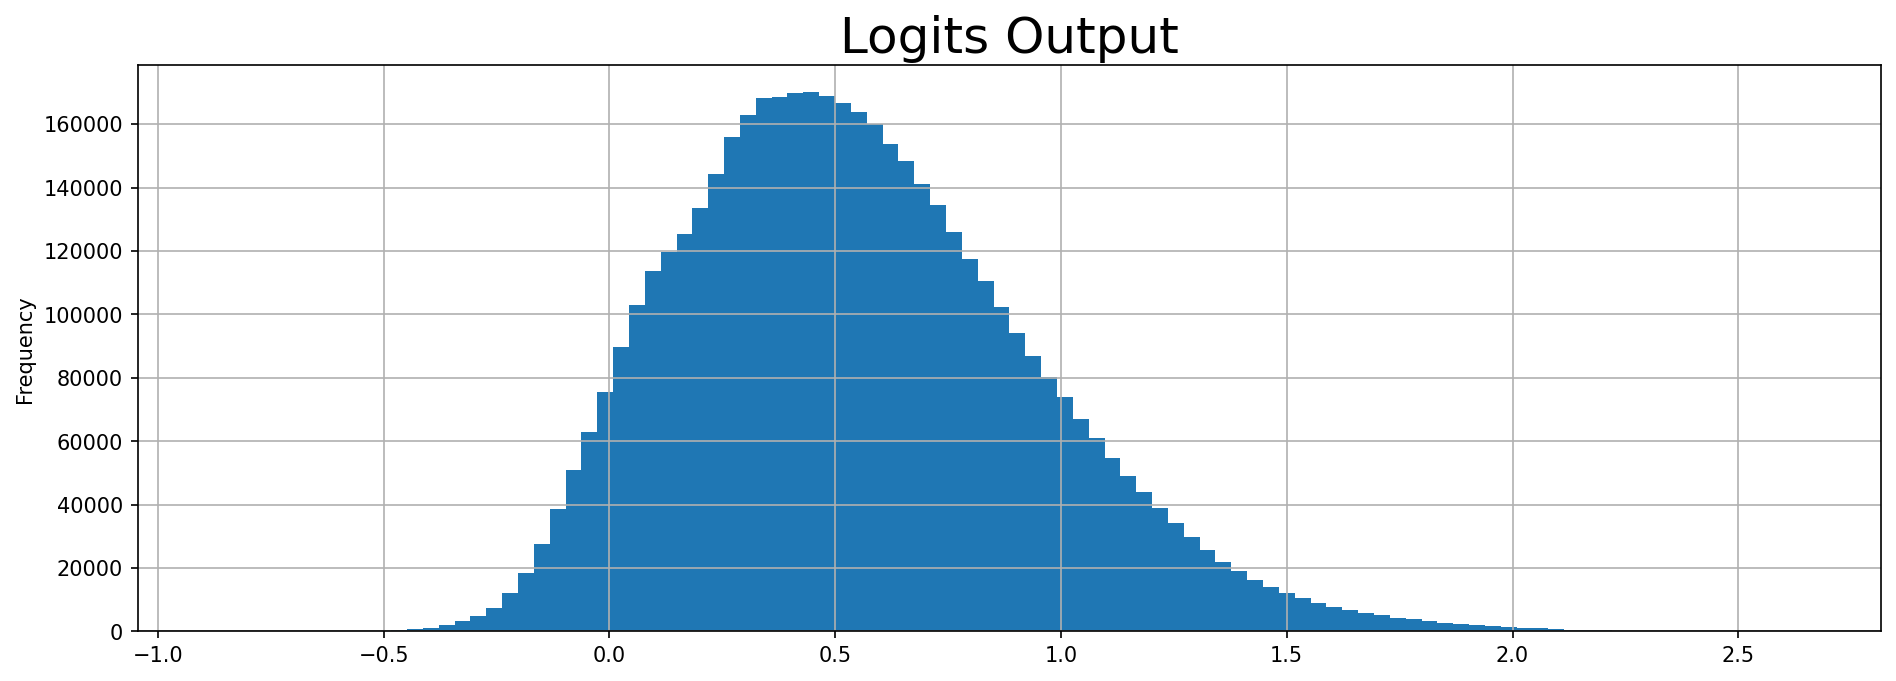

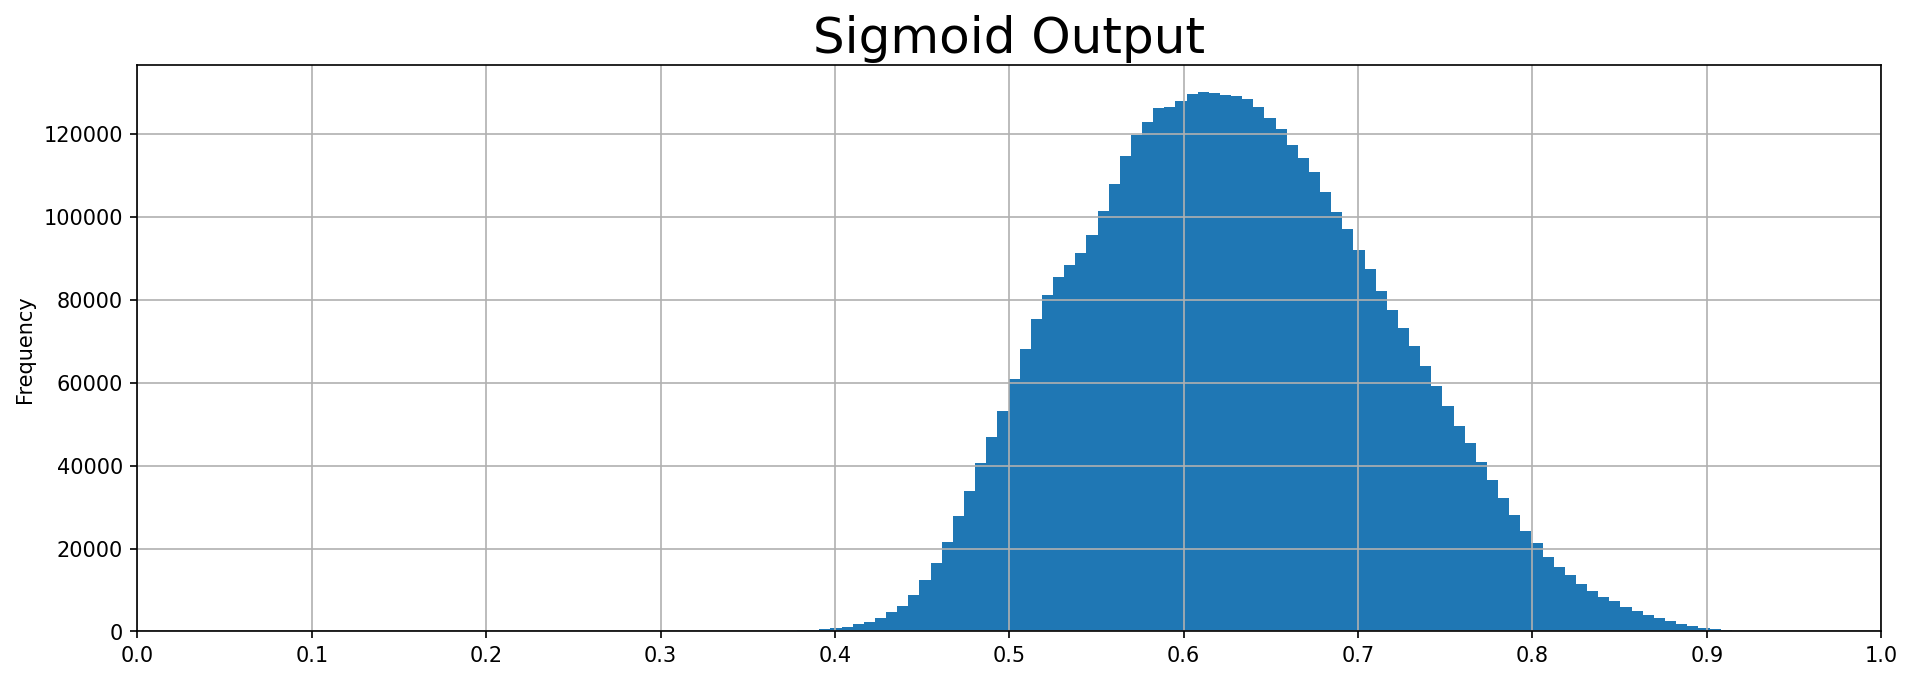

In [38]:
def weight_init_analysis():
    # Get large batch
    images, _ = next(iter(get_dataset(bs=8, debug=True)))
    print(f'images shape: {images.shape}')
    
    tf.keras.backend.clear_session()
    gc.collect()
    model = get_model(file_path=None, debug=True)
    
    (
        image_norm,
        embedding, up6, up5, up4, up3, up2, up1,
        dec0, x0, xs0, xs1, xs2, xs3, xs4, 
        dec1, dec1_up, dec1_concat,
        dec2, dec2_up, dec2_concat,
        dec3, dec3_up, dec3_concat,
        dec4, dec4_up, dec4_concat,
        dec_fpn, dec_fpn_xs, output
    ) = model(images, training=False) 

    percentiles = [0.01, 0.05, 0.10, 0.25, 0.40, 0.50, 0.60, 0.75, 0.90, 0.95, 0.99]

    for v, v_name in zip(
        [image_norm, embedding, up6, up5, up4, up3, up2, up1, dec0, x0, xs0, xs1, xs2, xs3, xs4, dec1, dec1_up, dec1_concat, dec2, dec2_up, dec2_concat, dec3, dec3_up, dec3_concat, dec4, dec4_up, dec4_concat, dec_fpn, dec_fpn_xs, output],
        ['image_norm', 'embedding', 'up6', 'up5', 'up4', 'up3', 'up2', 'up1', 'dec0', 'x0', 'xs0', 'xs1', 'xs2', 'xs3', 'xs4', 'dec1', 'dec1_up', 'dec1_concat', 'dec2', 'dec2_up', 'dec2_concat', 'dec3', 'dec3_up', 'dec3_concat', 'dec4', 'dec4_up', 'dec4_concat', 'dec_fpn', 'dec_fpn_xs', 'output'],
    ):
        display(pd.Series(v.numpy().flatten()).describe(percentiles=percentiles).astype(float).round(2).to_frame(name=v_name).T)
        print('=' * 50)

    # Histogram
    plt.figure(figsize=(15,5))
    plt.title('Logits Output', size=24)
    pd.Series(output.numpy().flatten()).plot(kind='hist', bins=100)
    plt.grid()
    plt.show()

    # Histogram
    plt.figure(figsize=(15,5))
    plt.title('Sigmoid Output', size=24)
    pd.Series(tf.math.sigmoid(output).numpy().flatten()).plot(kind='hist', bins=100)
    plt.xticks(np.arange(0.0, 1.1, 0.1))
    plt.grid()
    plt.show()
    
weight_init_analysis()

In [39]:
gc.collect()

123890

# Learning Rate Scheduler

An learning rate scheduler is used with a cosine decay and exponential warmup.

In [40]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=EPOCHS_WHOLE):
    
    if current_step < num_warmup_steps:
        return lr_max * 0.50 ** (num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

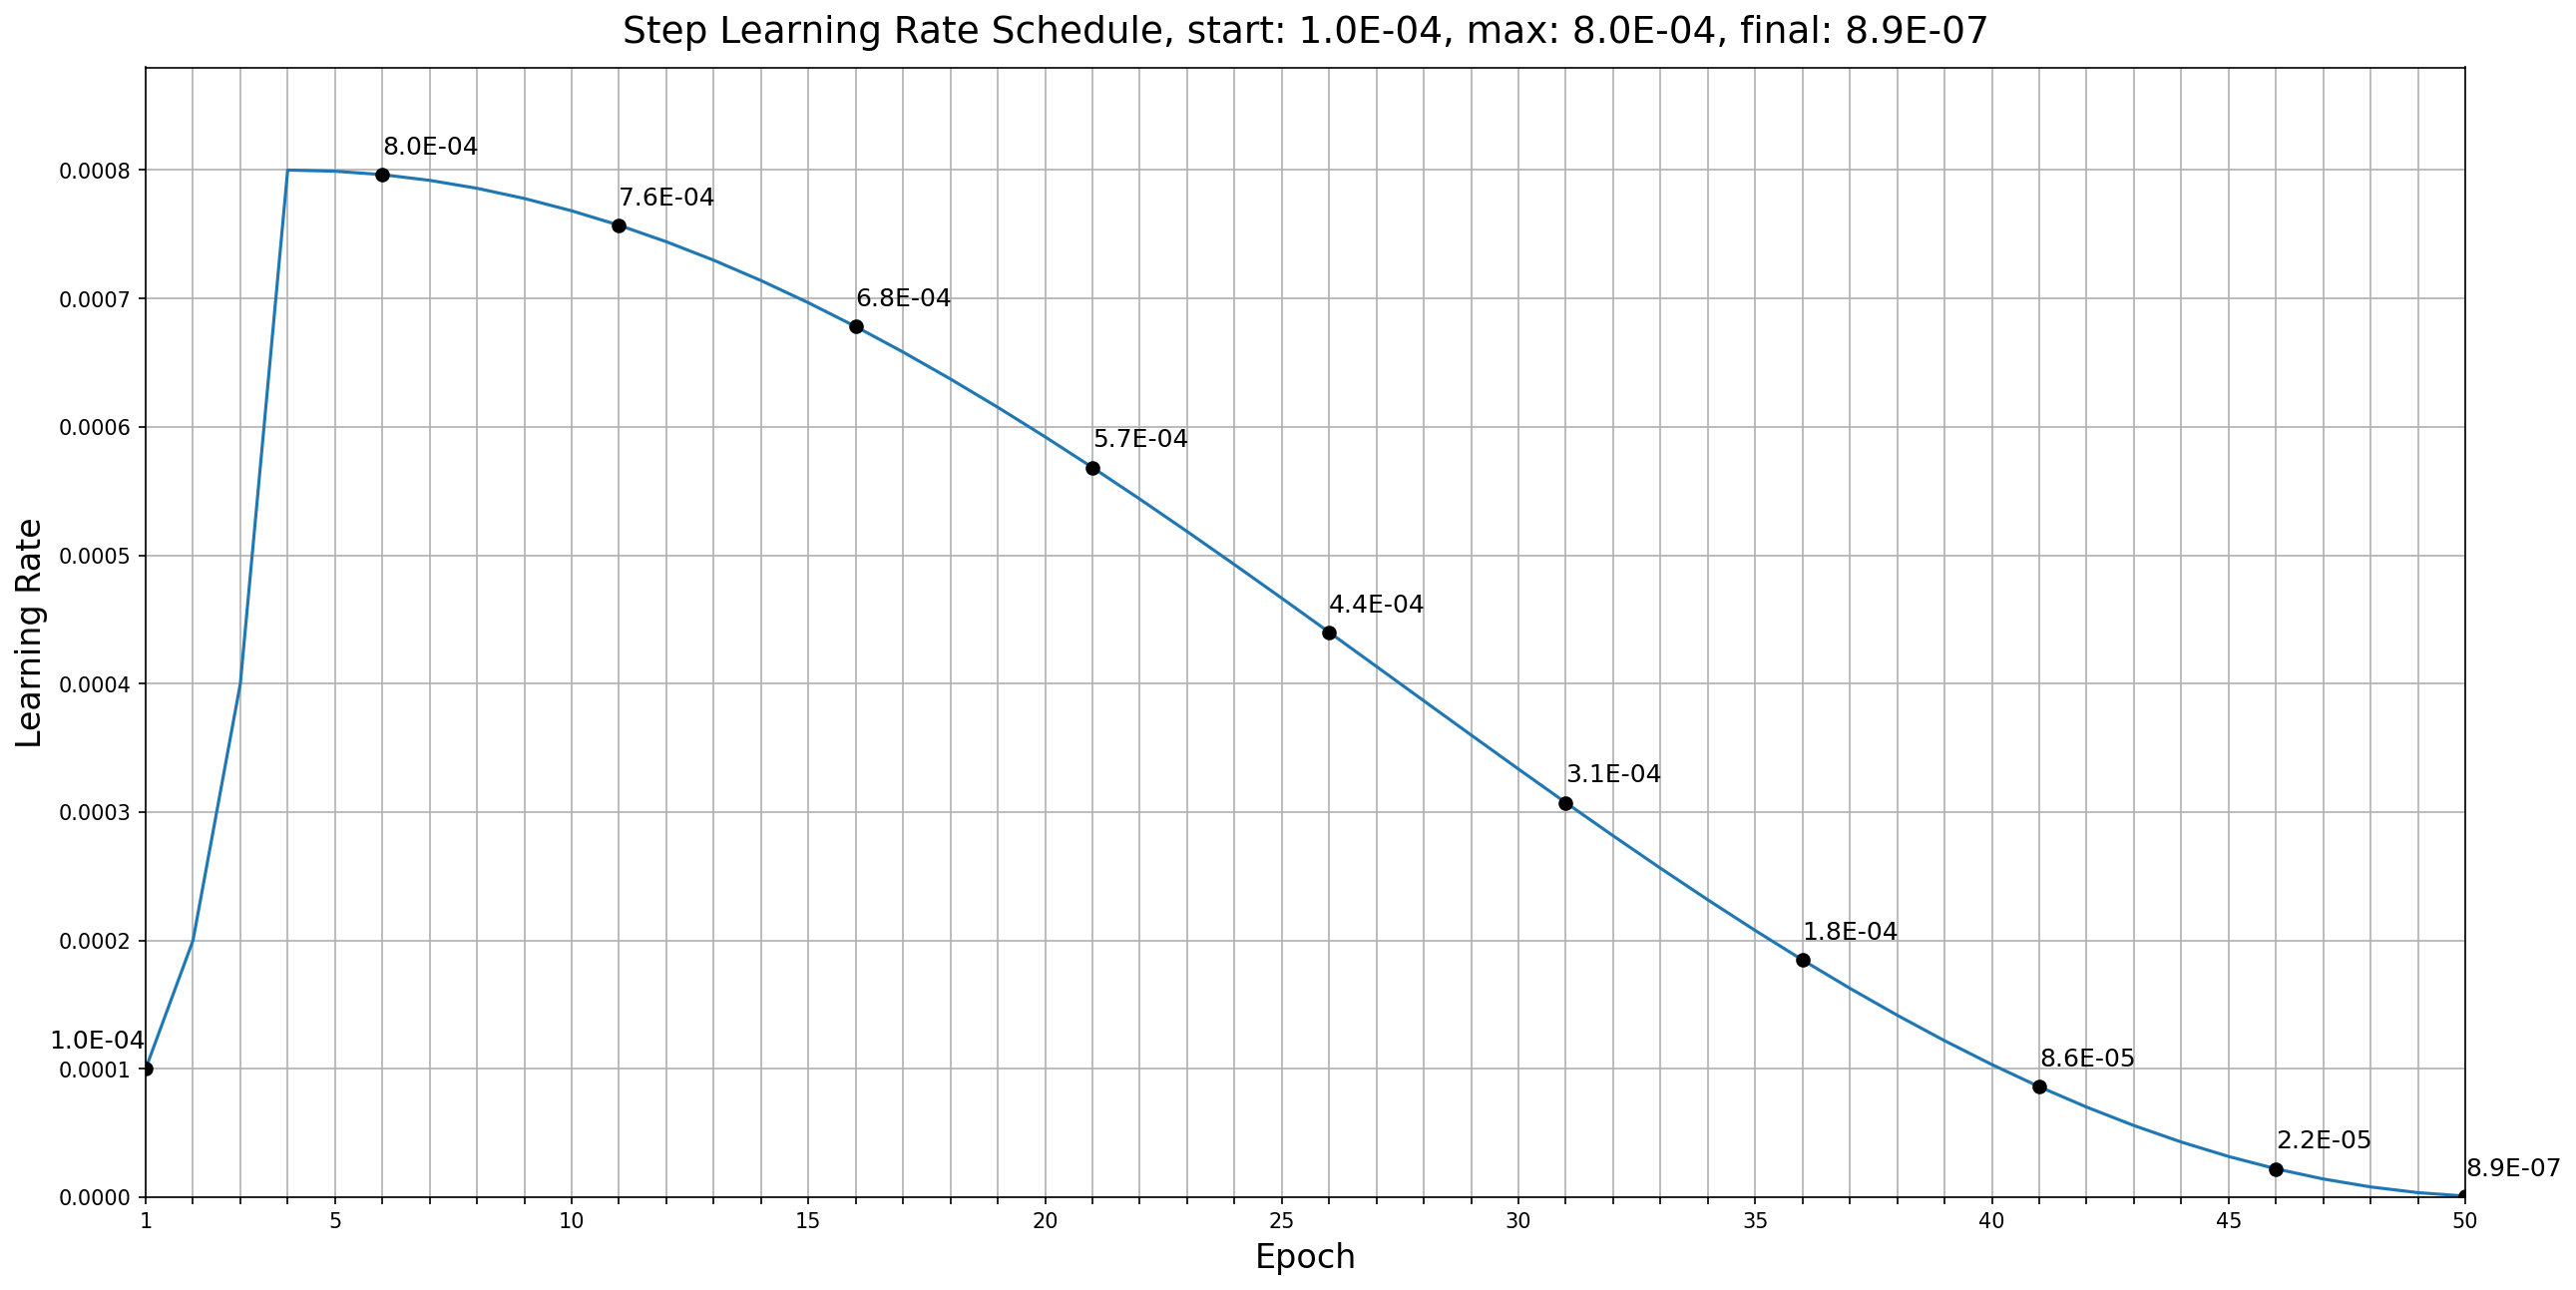

In [41]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=3, lr_max=LR_MAX_WHOLE, num_cycles=0.50) for step in range(EPOCHS_WHOLE)]
plot_lr_schedule(LR_SCHEDULE, epochs=EPOCHS_WHOLE)

# Training Whole Model

In [42]:
#ORGAN_PER_TFRECORD = np.load('../input/hubmap-patched-tfrecords-300x300/ORGAN_PER_TFRECORD.npy')
ORGAN_PER_TFRECORD = np.load(F'../input/{DATASET_SIZE_NAME}/ORGAN_PER_TFRECORD.npy')

In [43]:
print(ORGAN_PER_TFRECORD.shape)
print(TFRECORDS_FILE_PATHS.shape)

(351,)
(351,)


In [44]:
# Learning Rate Callback
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

In [45]:
def build_folds():
    if not os.path.exists(FOLD_FILE_PATH):
        print("[BUILD-FOLDS] GENERATE FOLDS")
        FOLDS = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
        idsx = { 'train_idxs': [], 'val_idxs': [], 'folds': [] }
        for fold, (train_idxs, val_idxs) in enumerate(FOLDS.split(X=TFRECORDS_FILE_PATHS, y=ORGAN_PER_TFRECORD)):
            idsx['train_idxs'].append(train_idxs)
            idsx['val_idxs'].append(val_idxs)
            idsx['folds'].append(fold)
            
        # Save file
        with open(FOLD_FILE_PATH, 'wb') as f:
            pickle.dump(idsx, f)
    else:
        print("[BUILD-FOLDS] READ FOLDS")
        # Read file
        with open(FOLD_FILE_PATH, 'rb') as f:
            idsx = pickle.load(f)
            
    return idsx


In [46]:
IDXS = build_folds()
print("[SPLIT-FOLDS]", "keys:", IDXS.keys(), "folds", IDXS['folds'])
for fold, train_idxs, val_idxs in zip(IDXS['folds'], IDXS['train_idxs'], IDXS['val_idxs']):
    print('[SPLIT-FOLDS] SIZE_FOLD', fold, len(train_idxs), len(val_idxs))

[BUILD-FOLDS] READ FOLDS
[SPLIT-FOLDS] keys: dict_keys(['train_idxs', 'val_idxs', 'folds']) folds [0, 1, 2, 3]
[SPLIT-FOLDS] SIZE_FOLD 0 263 88
[SPLIT-FOLDS] SIZE_FOLD 1 263 88
[SPLIT-FOLDS] SIZE_FOLD 2 263 88
[SPLIT-FOLDS] SIZE_FOLD 3 264 87


In [47]:
#!rm ./dict_indxs_fold4.pickle
#!rm ./dict_fold_4.pickle
#!rm ./best_model_0.h5
#!rm ./model_0.h5
TRAIN_FOLDS = [3] #3
TRAIN_FOLDS

[3]

In [48]:
!rm './folds/dict_indxs_fold4.pickle'

In [49]:
# Create KFOLDS
HISTORIES = dict()
for fold, train_idxs, val_idxs in zip(IDXS['folds'], IDXS['train_idxs'], IDXS['val_idxs']):
    out_dir = os.path.join(CHECKPOINTS_DIR, F"fold{fold}")
    os.makedirs(out_dir, exist_ok=True)
    print("[TRAIN] OUT_DIR:", out_dir)
    # Only train selected folds
    print('=' * 80)
    print("TRAIN_FOLDS:", TRAIN_FOLDS)
    print('=' * 80)
    if fold not in TRAIN_FOLDS:
        continue
    
    IDXS['train_idxs'].append(train_idxs)
    IDXS['val_idxs'].append(val_idxs)
    train_dataset, train_steps_per_epoch = get_dataset(tfrecord_idxs=train_idxs, bs=BATCH_SIZE, return_steps=True)
    val_dataset, val_steps_per_epoch = get_dataset(tfrecord_idxs=val_idxs, bs=N_PATCHES_PER_IMAGE * REPLICAS, return_steps=True, val=True)
    print('=' * 80)
    print(f'FOLD {fold}, train_steps_per_epoch: {train_steps_per_epoch}, val_steps_per_epoch: {val_steps_per_epoch}')
    print('=' * 80)
    
    tf.keras.backend.clear_session()
    gc.collect()
    
    model = get_model(file_path=None, cnn_trainable=True, lr=LR_MAX_WHOLE, eps=1e-5)
    #model = get_model(file_path='../input/hubmap-training-tf-tpu-efficientnet-b8-640640-p/model_0.h5', cnn_trainable=True, lr=LR_MAX_WHOLE, eps=1e-5)
    #if fold == TRAIN_FOLDS[0]:
    #    print(model.summary())
    
    # Learning Rate Callback
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)
    # Checkpoints
    mcp_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(out_dir, F"best_model_{fold}.h5"), 
                                                      monitor='val_loss',
                                                      save_best_only=True, 
                                                      save_weights_only=True,
                                                      mode='min', verbose=True)
    # Early Stopping
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    history = model.fit(
        train_dataset,
        steps_per_epoch = train_steps_per_epoch * COMBINE_EPOCHS,
        validation_data = val_dataset,
        epochs = EPOCHS_WHOLE,
        verbose = 2,
        callbacks = [
            lr_callback,
            mcp_callback, 
            es_callback, 
        ],
    )
    
    # Save Results
    model.save_weights(os.path.join(out_dir, F"model_{fold}.h5"))
    
    # Save history
    history_path = os.path.join(out_dir, F"history_fold{fold}.csv")
    print("[TRAIN] HISTORY_PATH:", history_path)
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    history_df.to_csv(history_path, index=False)
    
    del model
    HISTORIES[fold] = history
    
    print('\n' * 3)
    
    #break

[TRAIN] OUT_DIR: /kaggle/working/checkpoints/fold0
TRAIN_FOLDS: [3]
[TRAIN] OUT_DIR: /kaggle/working/checkpoints/fold1
TRAIN_FOLDS: [3]
[TRAIN] OUT_DIR: /kaggle/working/checkpoints/fold2
TRAIN_FOLDS: [3]
[TRAIN] OUT_DIR: /kaggle/working/checkpoints/fold3
TRAIN_FOLDS: [3]
FOLD 3, train_steps_per_epoch: 9, val_steps_per_epoch: 11
ENABLED TPU
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
36/36 - 410s - loss: 0.3833 - iou: 0.0615 - precision: 0.2101 - recall: 0.1004 - auc: 0.6610 - binary_accuracy: 0.8549 - val_loss: 0.4600 - val_iou: 0.0332 - val_precision: 0.8371 - val_recall: 0.0490 - val_auc: 0.5973 - val_binary_accuracy: 0.8994


2022-09-21 18:07:32.667999: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 213245, Output num: 3
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1663783652.667897611","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 213245, Output num: 3","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.45996, saving model to /kaggle/working/checkpoints/fold3/best_model_3.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002.
36/36 - 42s - loss: 0.2207 - iou: 0.3461 - precision: 0.6547 - recall: 0.4153 - auc: 0.9085 - binary_accuracy: 0.9072 - val_loss: 0.2238 - val_iou: 0.1745 - val_precision: 0.8969 - val_recall: 0.2313 - val_auc: 0.9009 - val_binary_accuracy: 0.9167

Epoch 00002: val_loss improved from 0.45996 to 0.22378, saving model to /kaggle/working/checkpoints/fold3/best_model_3.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0004.
36/36 - 42s - loss: 0.1807 - iou: 0.4514 - precision: 0.6961 - recall: 0.5582 - auc: 0.9426 - binary_accuracy: 0.9210 - val_loss: 0.1341 - val_iou: 0.5474 - val_precision: 0.7288 - val_recall: 0.7789 - val_auc: 0.9688 - val_binary_accuracy: 0.9465

Epoch 00003: val_loss improved from 0.22378 to 0.13410, saving model to /kaggle/working/checkpoints

# Zip Results

In [50]:
# Delete old zip
!rm *.zip

rm: cannot remove '*.zip': No such file or directory


In [51]:
# Zip new models
!zip -r checkpoints.zip checkpoints
!zip -r folds.zip folds 

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/fold3/ (stored 0%)
  adding: checkpoints/fold3/history_fold3.csv (deflated 51%)
  adding: checkpoints/fold3/model_3.h5 (deflated 7%)
  adding: checkpoints/fold3/best_model_3.h5 (deflated 7%)
  adding: checkpoints/fold2/ (stored 0%)
  adding: checkpoints/fold2/best_model_2.h5 (deflated 7%)
  adding: checkpoints/fold2/model_2.h5 (deflated 7%)
  adding: checkpoints/fold2/history_fold2.csv (deflated 50%)
  adding: checkpoints/fold0/ (stored 0%)
  adding: checkpoints/fold0/model_0.h5 (deflated 7%)
  adding: checkpoints/fold0/history_fold0.csv (deflated 50%)
  adding: checkpoints/fold0/best_model_0.h5 (deflated 7%)
  adding: checkpoints/fold1/ (stored 0%)
  adding: checkpoints/fold1/model_1.h5 (deflated 7%)
  adding: checkpoints/fold1/best_model_1.h5 (deflated 7%)
  adding: checkpoints/fold1/history_fold1.csv (deflated 50%)
  adding: folds/ (stored 0%)


In [52]:
# Lst files
!ls -lh

total 2.9G
---------- 1 root root 5.3M Sep 21 18:24 __notebook__.ipynb
drwxr-xr-x 6 root root 4.0K Sep 21 17:53 checkpoints
-rw-r--r-- 1 root root 2.9G Sep 21 18:24 checkpoints.zip
drwxr-xr-x 2 root root 4.0K Sep 21 17:53 fold1
drwxr-xr-x 2 root root 4.0K Sep 21 17:59 folds
-rw-r--r-- 1 root root  162 Sep 21 18:24 folds.zip
-rw-r--r-- 1 root root 1.1M Sep 21 17:57 model.png
drwxr-xr-x 3 root root 4.0K Sep 21 17:54 models
drwxr-xr-x 2 root root 4.0K Sep 21 17:54 predictions


# Training Visualisation

Training and validation predictions are plotted as a sanity check.

In [53]:
def plot_results(dataset, nrows, ncols=4):
    images, labels = next(iter(dataset))
    
    # Predict Masks
    labels_pred = model(images, training=False)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8, nrows*6))
    
    for r, (img, lbl, lbl_pred) in enumerate(zip(images, labels, labels_pred)):
        if r > nrows - 1: # zero indexed
            break
        # Plot Image
        axes[r, 0].imshow(img)
        axes[r, 0].set_title('Image', size=18)
        axes[r, 0].axis(False)
        
        # Mask
        axes[r, 1].imshow(lbl)
        axes[r, 1].set_title('Mask', size=18)
        axes[r, 1].axis(False)
        
        # Predicted Mask with Threshold
        axes[r, 2].imshow(lbl_pred)
        axes[r, 2].set_title('Mask Predicted', size=18)
        axes[r, 2].axis(False)
        
        # Predicted Mask with Threshold
        lbl_pred_th50 =tf.cast(lbl_pred > 0.50, tf.uint8)
        axes[r, 3].imshow(lbl_pred_th50)
        axes[r, 3].set_title('Mask Predicted Threshold 0.50', size=18)
        axes[r, 3].axis(False)

In [54]:
# Training Visualisation
#plot_results(get_dataset(bs=8, idxs=train_idxs), 8)

In [55]:
# Validation Visualisation
#plot_results(get_dataset(bs=8, idxs=val_idxs, val=True), 8)

# Training History

Plot training history metrics to get an understanding on how the model is learning.

In [56]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    for fold, history in HISTORIES.items():
        #values = history.history[metric]
        values = history[metric]
        N_EPOCHS = len(values)
        #val = 'val' in ''.join(history.history.keys())
        val = 'val' in ''.join(history.keys())
        # Epoch Ticks
        if N_EPOCHS <= 20:
            x = np.arange(1, N_EPOCHS + 1)
        else:
            x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]
        x_ticks = np.arange(1, N_EPOCHS+1)
        #print(x)
        # Validation
        if val:
            #val_values = history.history[f'val_{metric}']
            val_values = history[f'val_{metric}']
            val_argmin = f_best(val_values)
            plt.plot(x_ticks, val_values, label=f'val_fold_{fold}')

        # summarize history for accuracy
        plt.plot(x_ticks, values, label=f'train_fold_{fold}')
        argmin = f_best(values)
        plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best_fold_{fold}')
        if val:
            plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best_fold_{fold}')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

In [57]:
def load_histories():
    histories = {}
    if os.path.exists(CHECKPOINTS_DIR):
        for fold in range(N_FOLDS):
            history_path = os.path.join(CHECKPOINTS_DIR, F"fold{fold}", F"history_fold{fold}.csv")
            if not os.path.exists(history_path):
                print("DOESNT EXISTS history_path", history_path)
                continue
            history = pd.read_csv(history_path)
            histories[fold] = history
    
    return histories

In [58]:
HISTORIES = load_histories()
        
HISTORIES.keys()

dict_keys([0, 1, 2, 3])

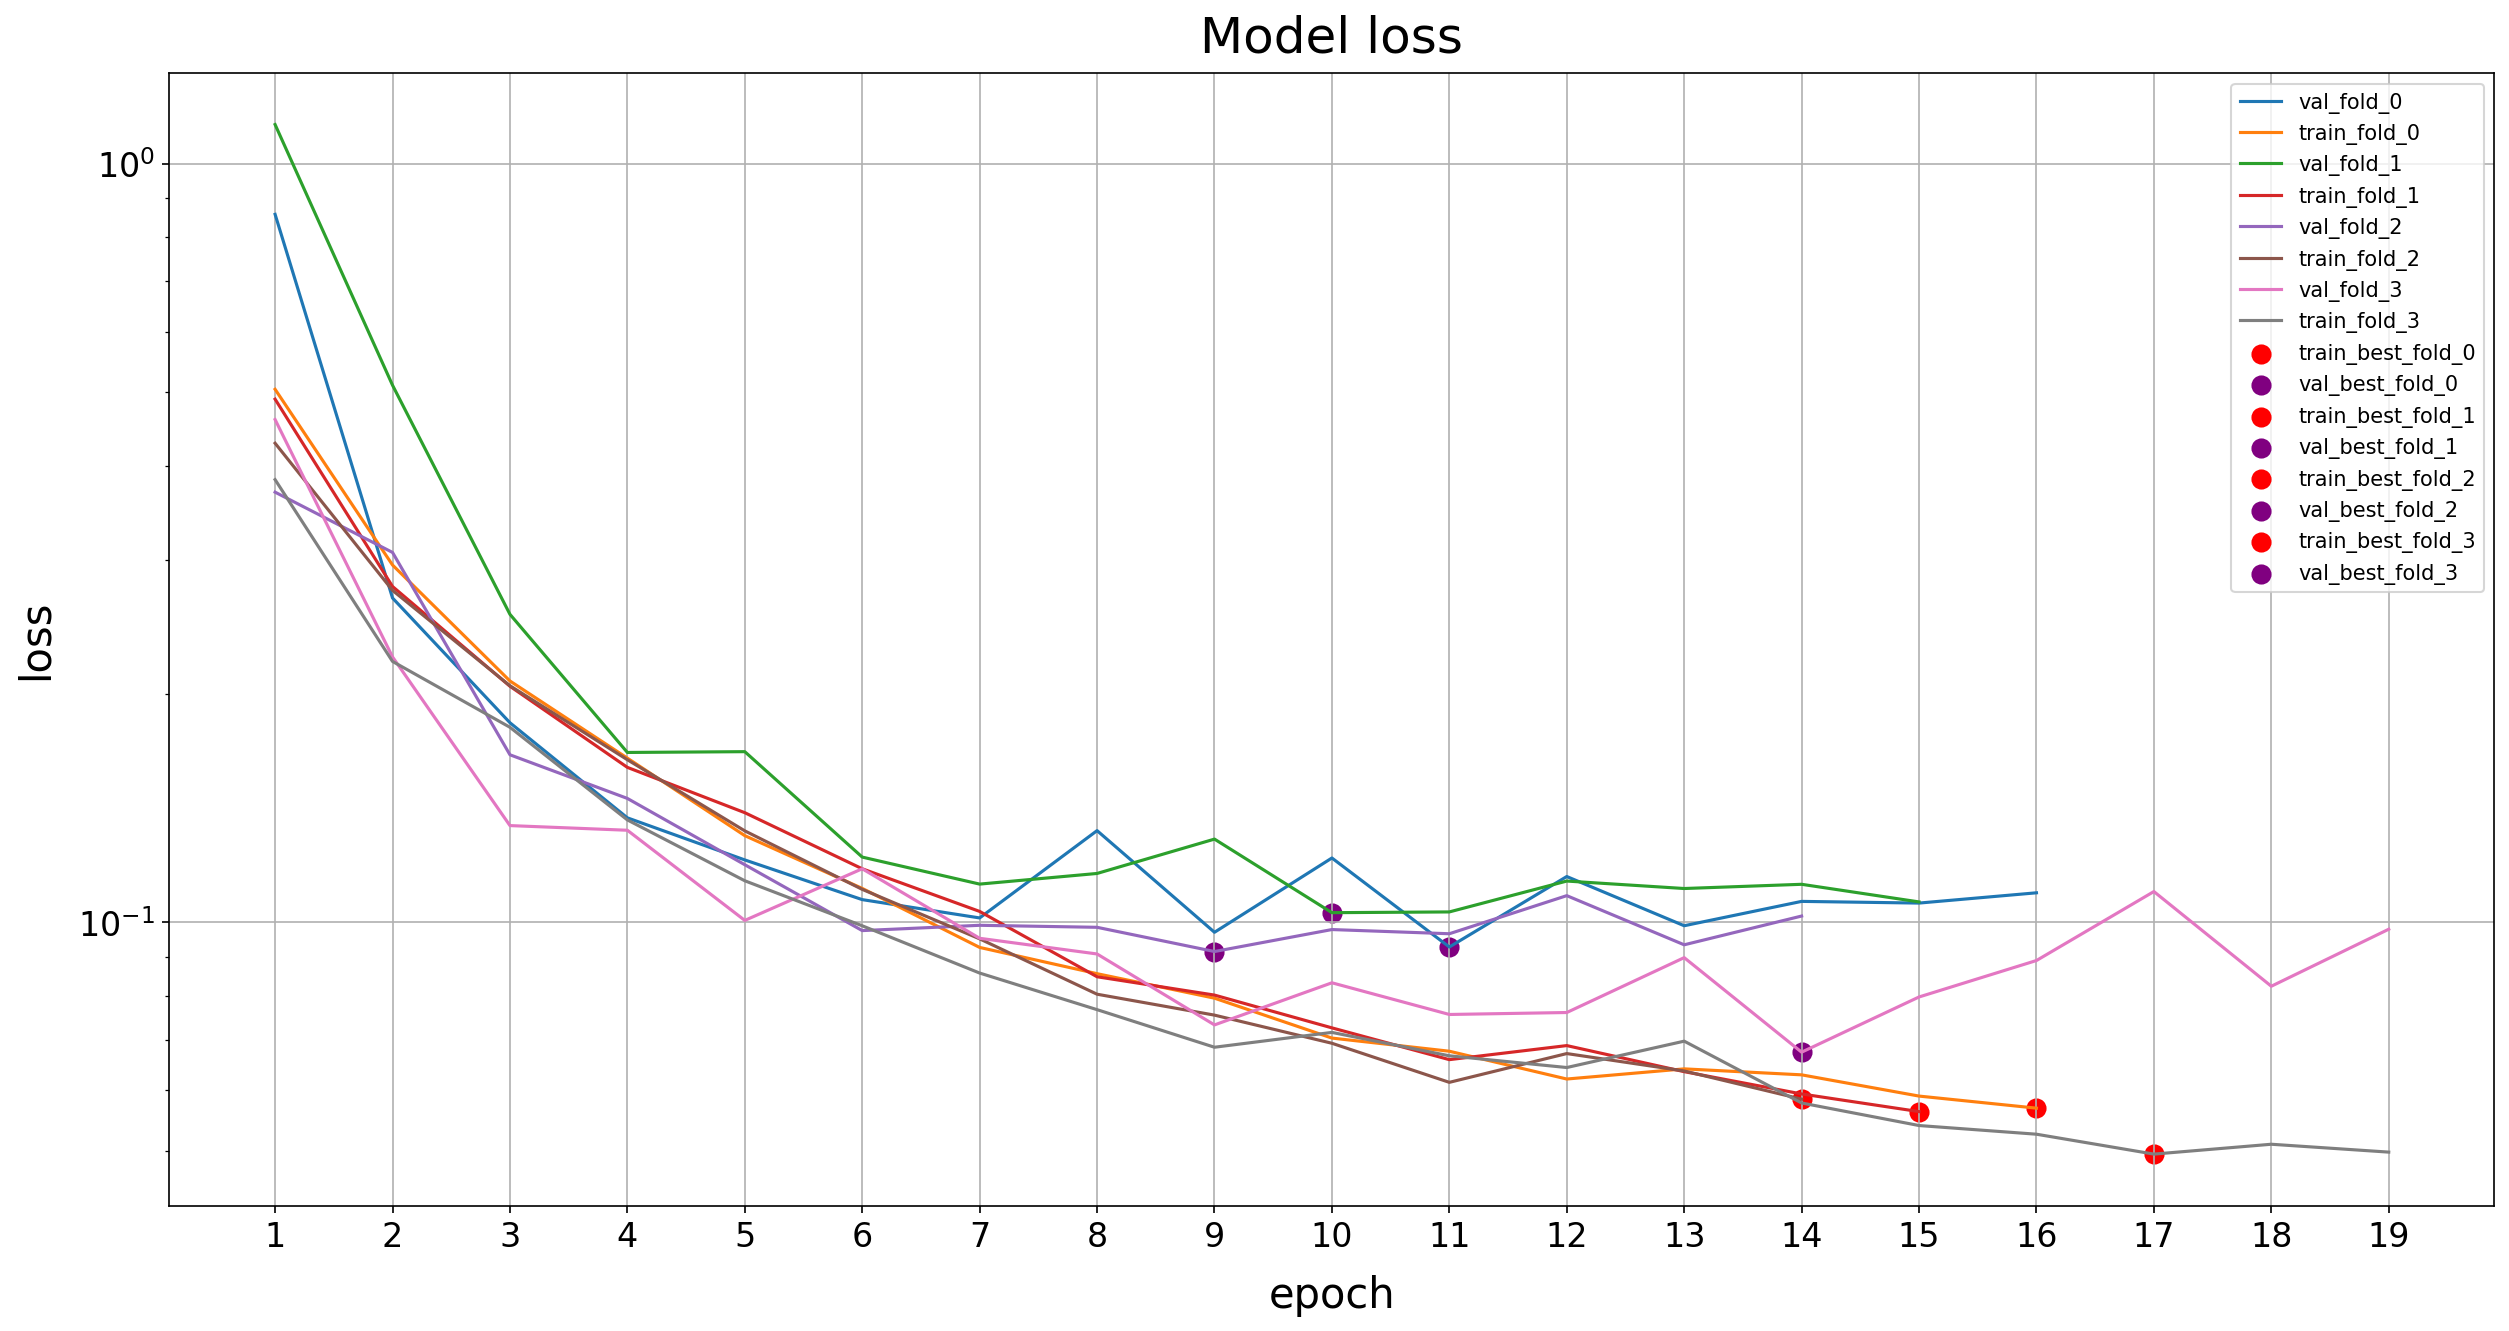

In [59]:
plot_history_metric('loss', f_best=np.argmin, yscale='log')

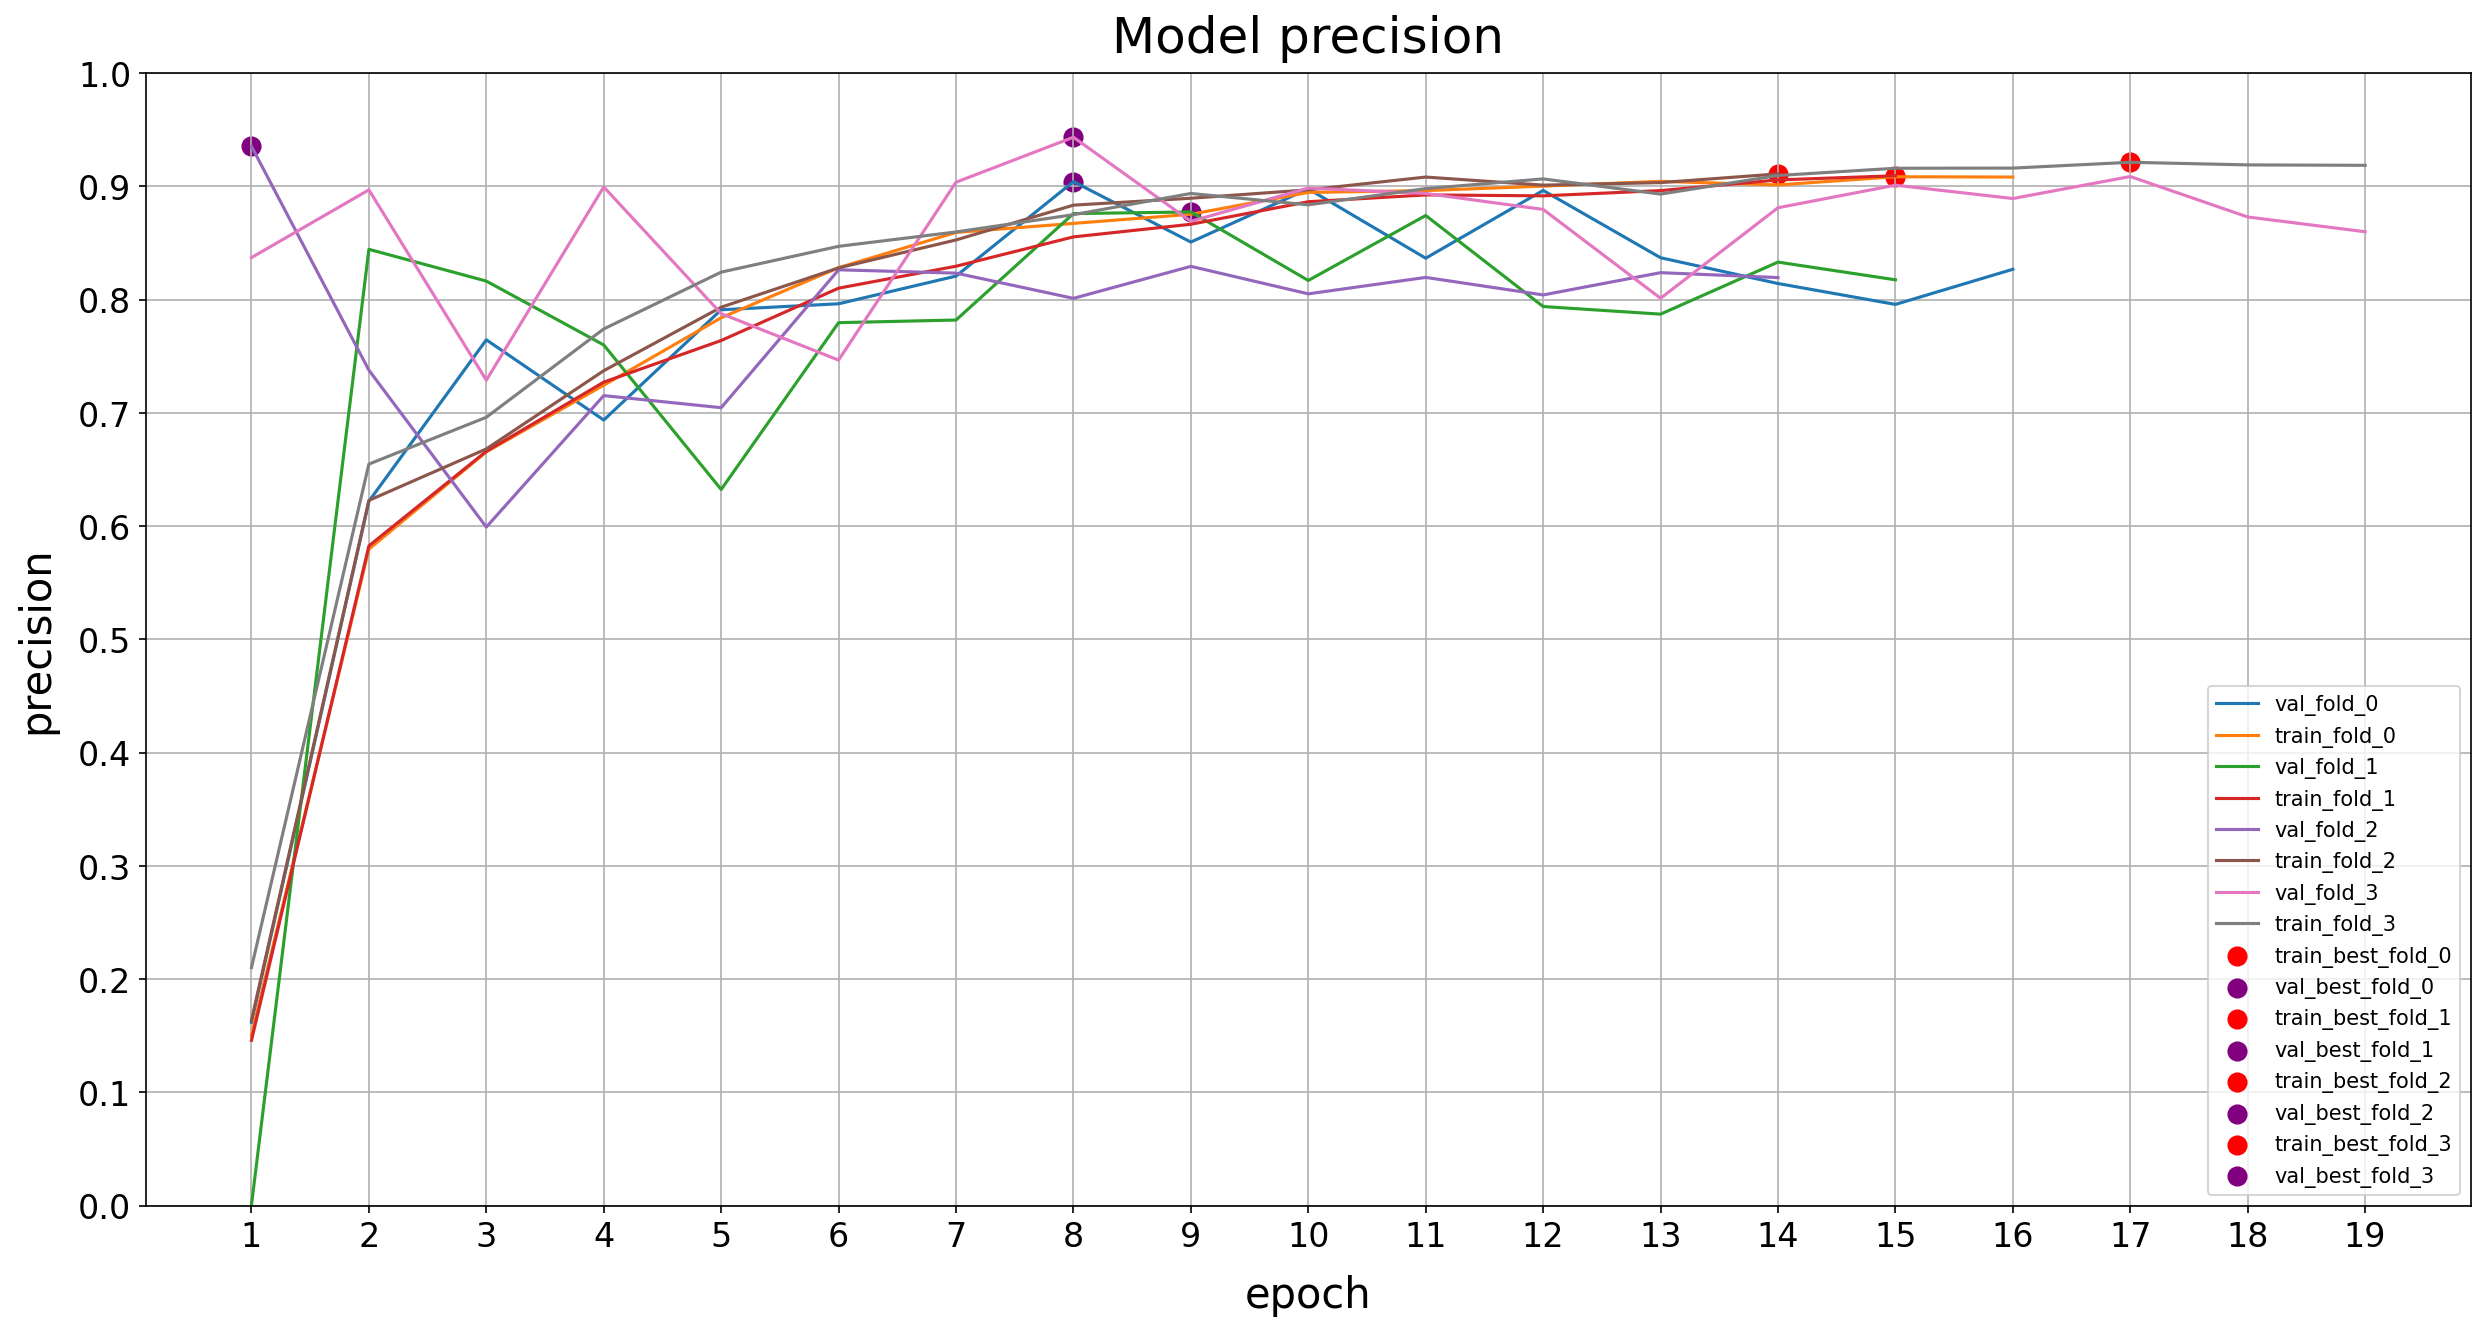

In [60]:
plot_history_metric('precision', ylim=(0,1), yticks=np.arange(0, 1.1, 0.1))

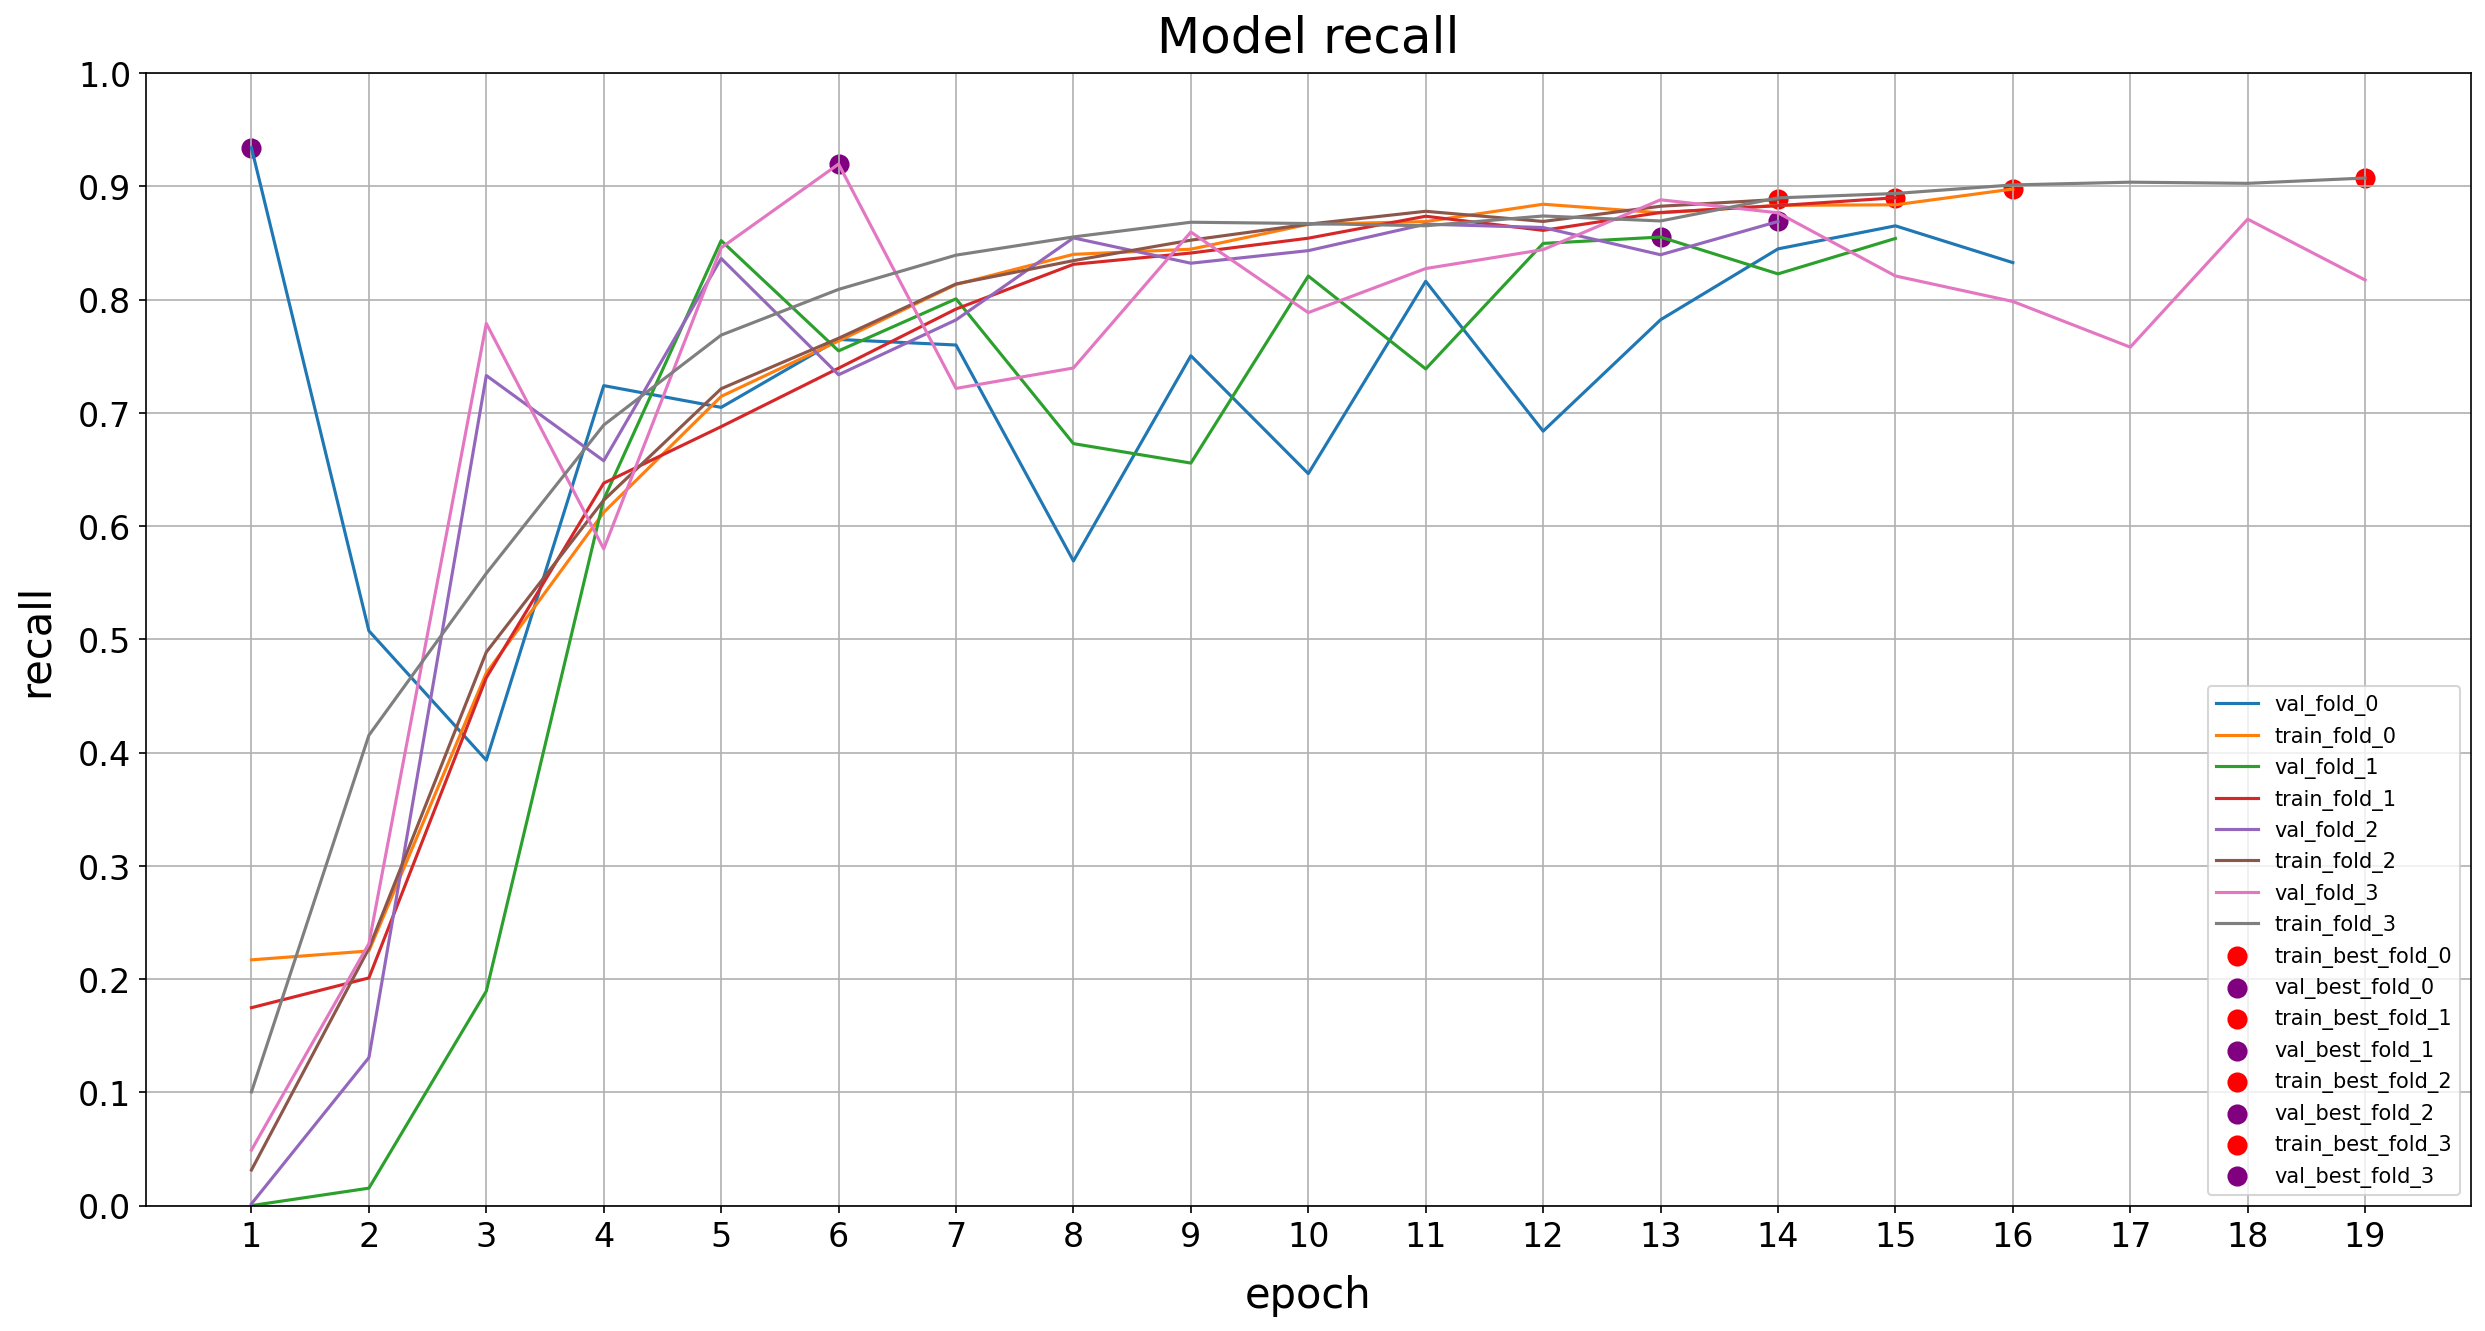

In [61]:
plot_history_metric('recall', ylim=(0,1), yticks=np.arange(0, 1.1, 0.1))

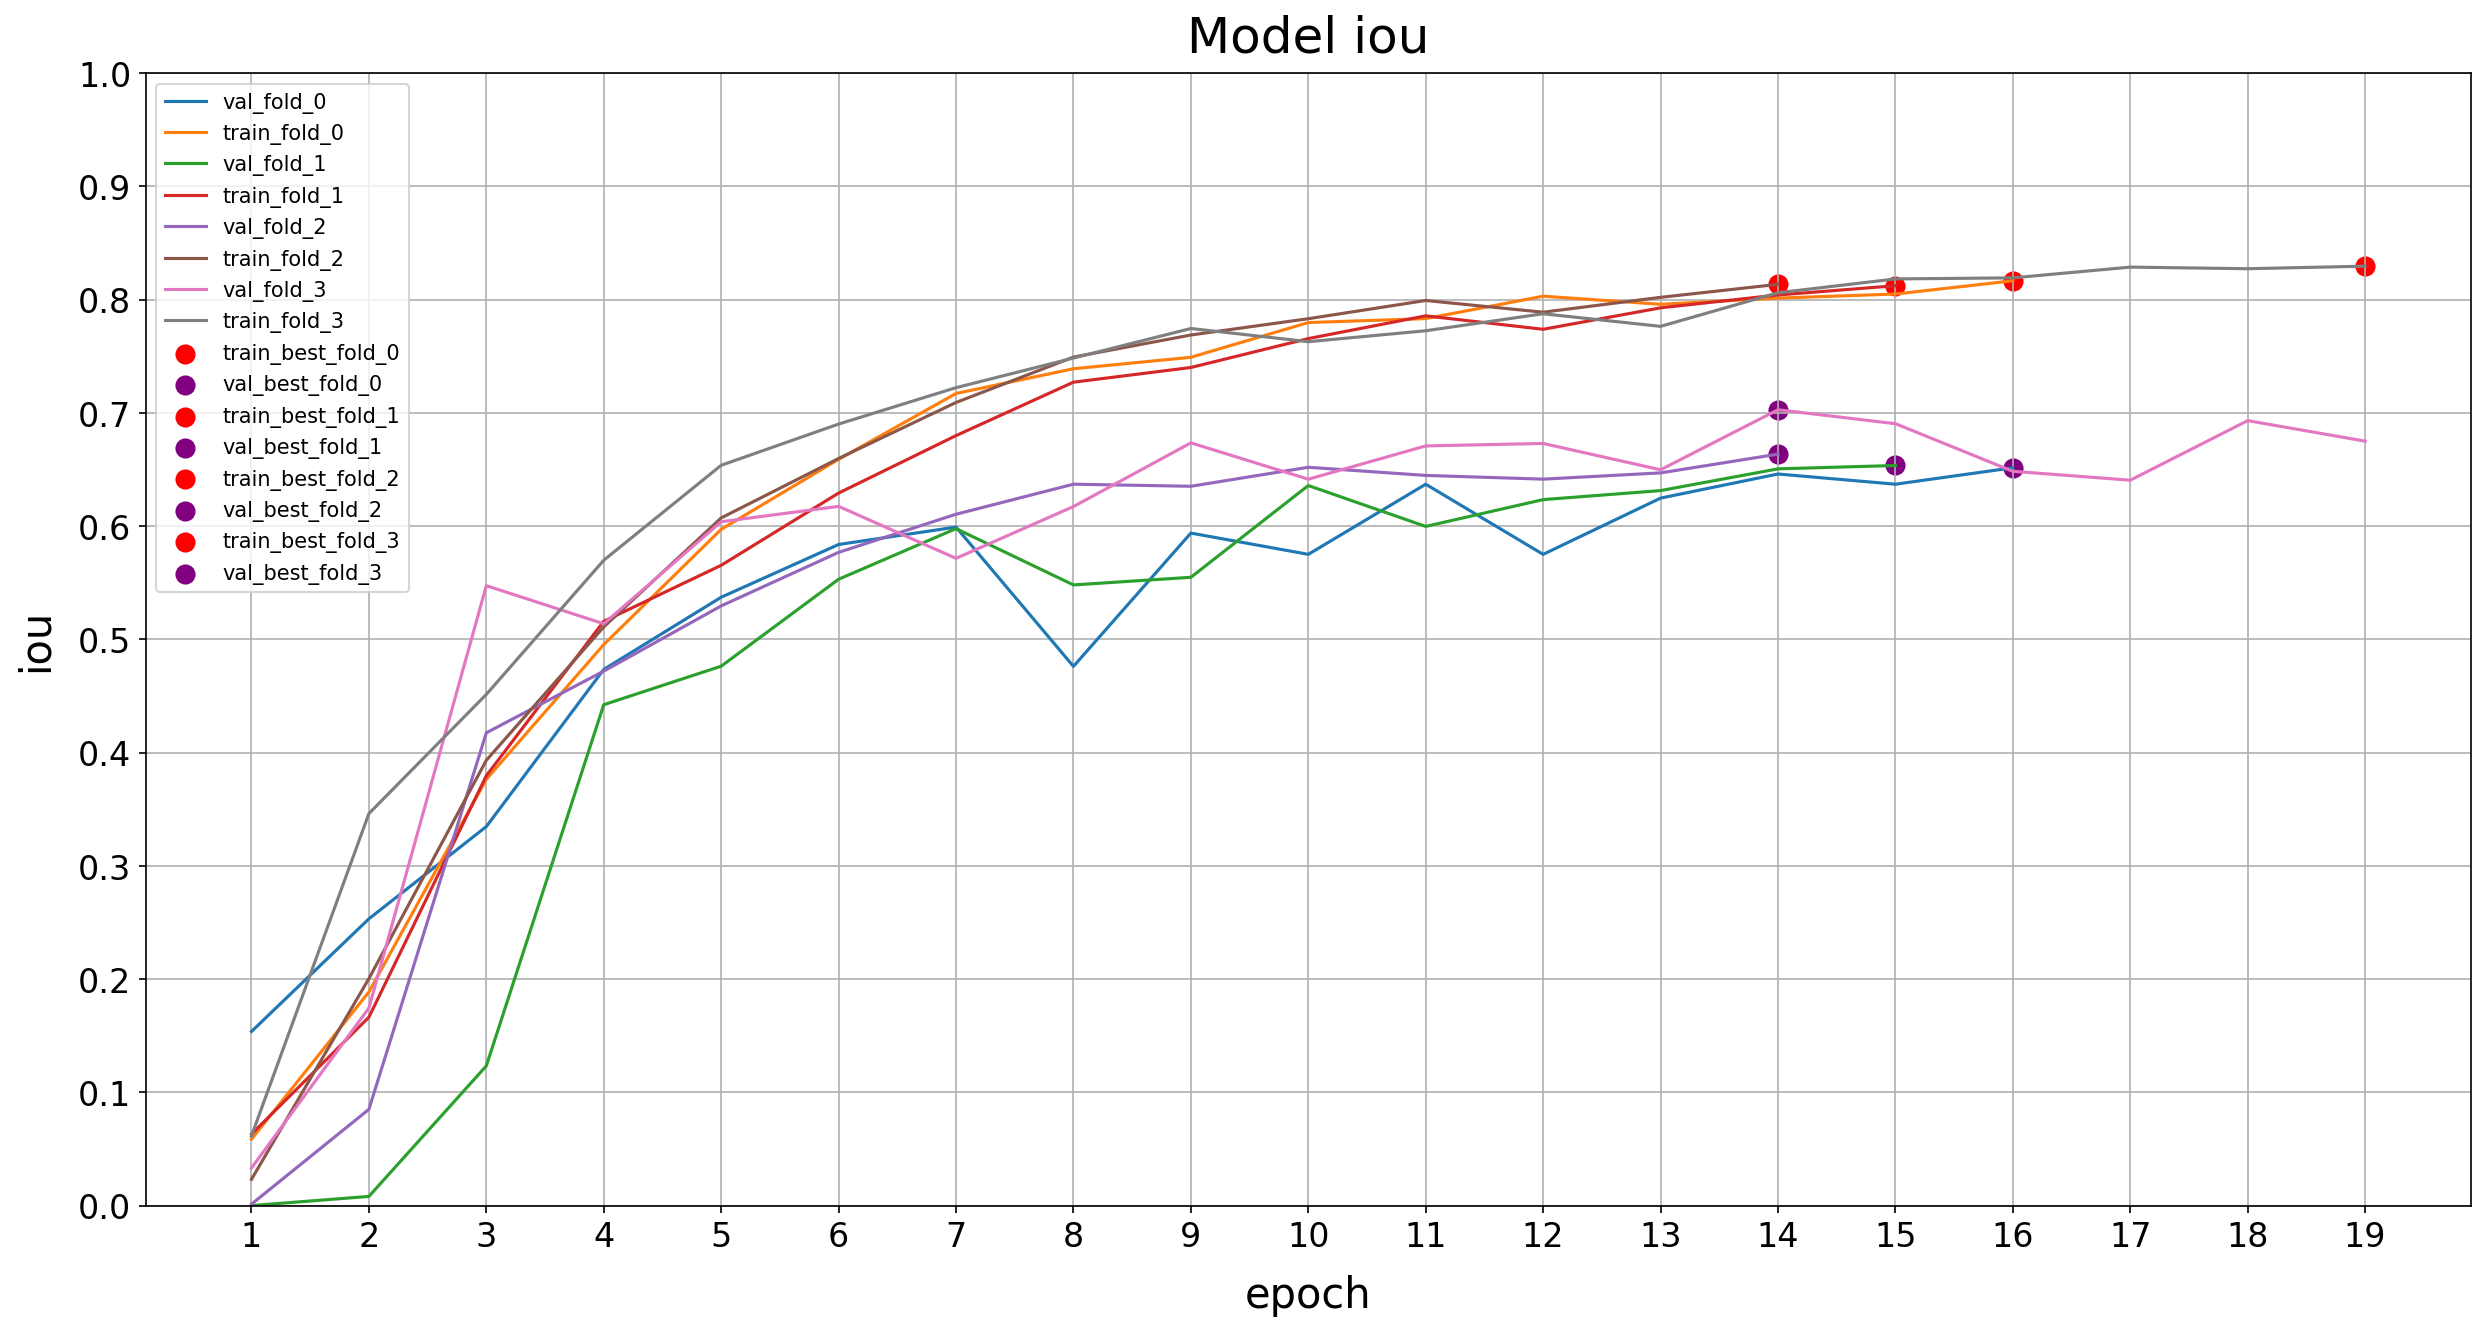

In [62]:
plot_history_metric('iou', ylim=(0,1), yticks=np.arange(0, 1.1, 0.1))

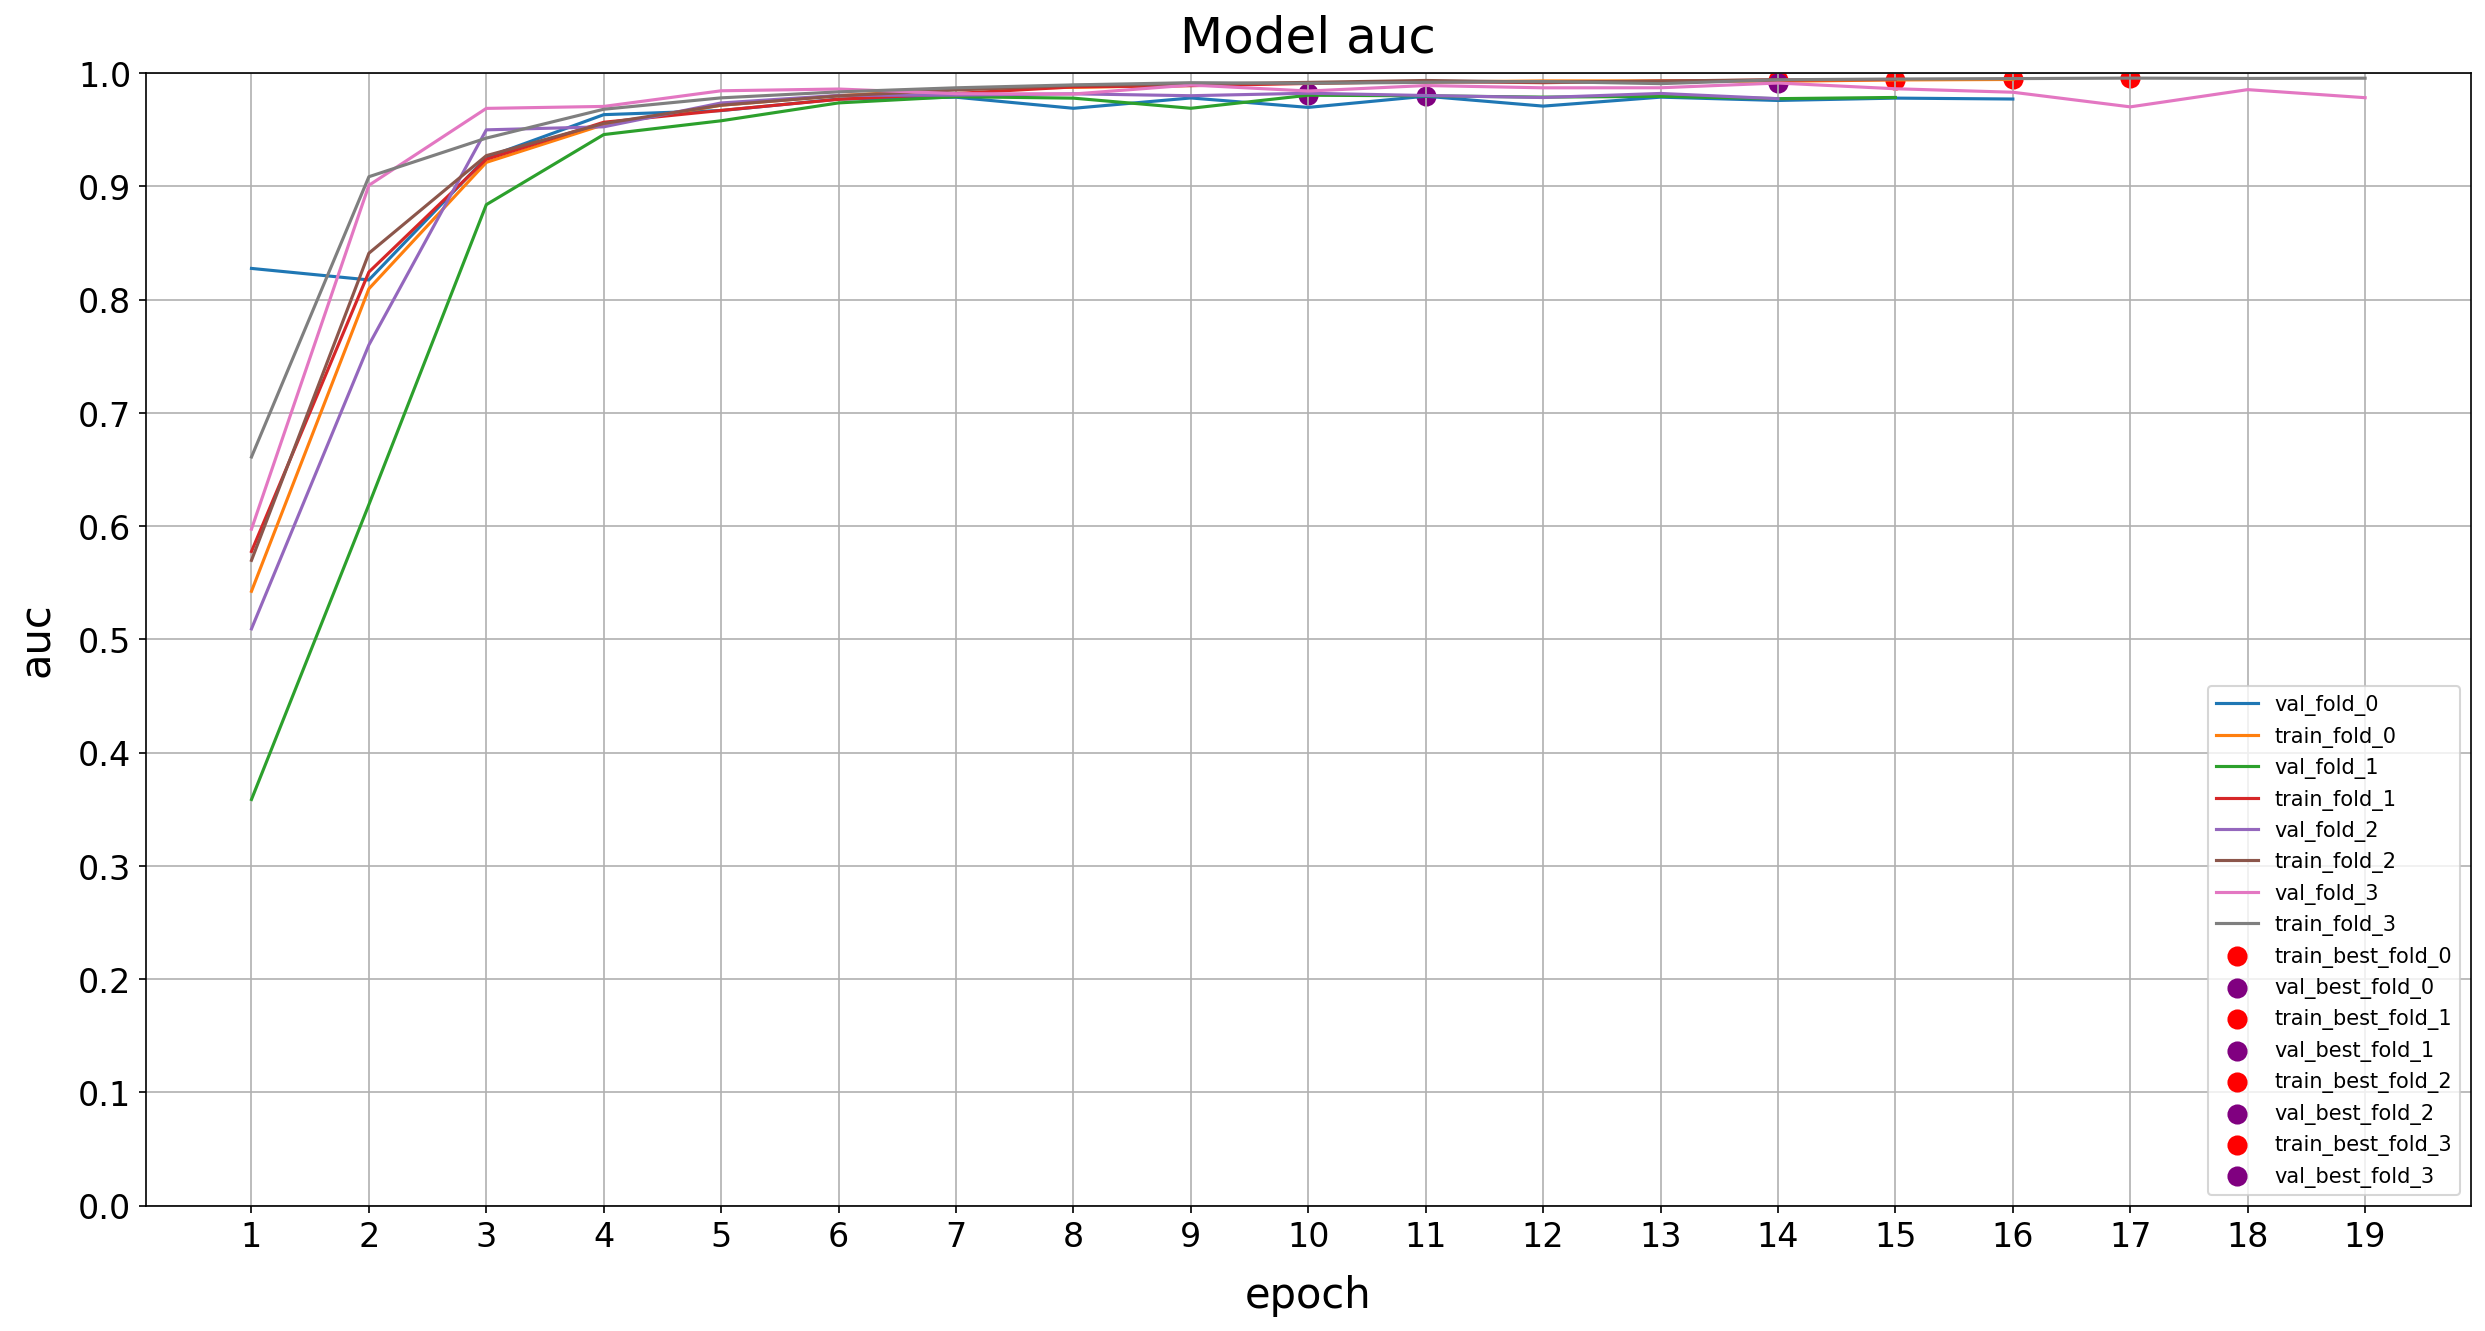

In [63]:
plot_history_metric('auc', ylim=(0,1), yticks=np.arange(0, 1.1, 0.1))

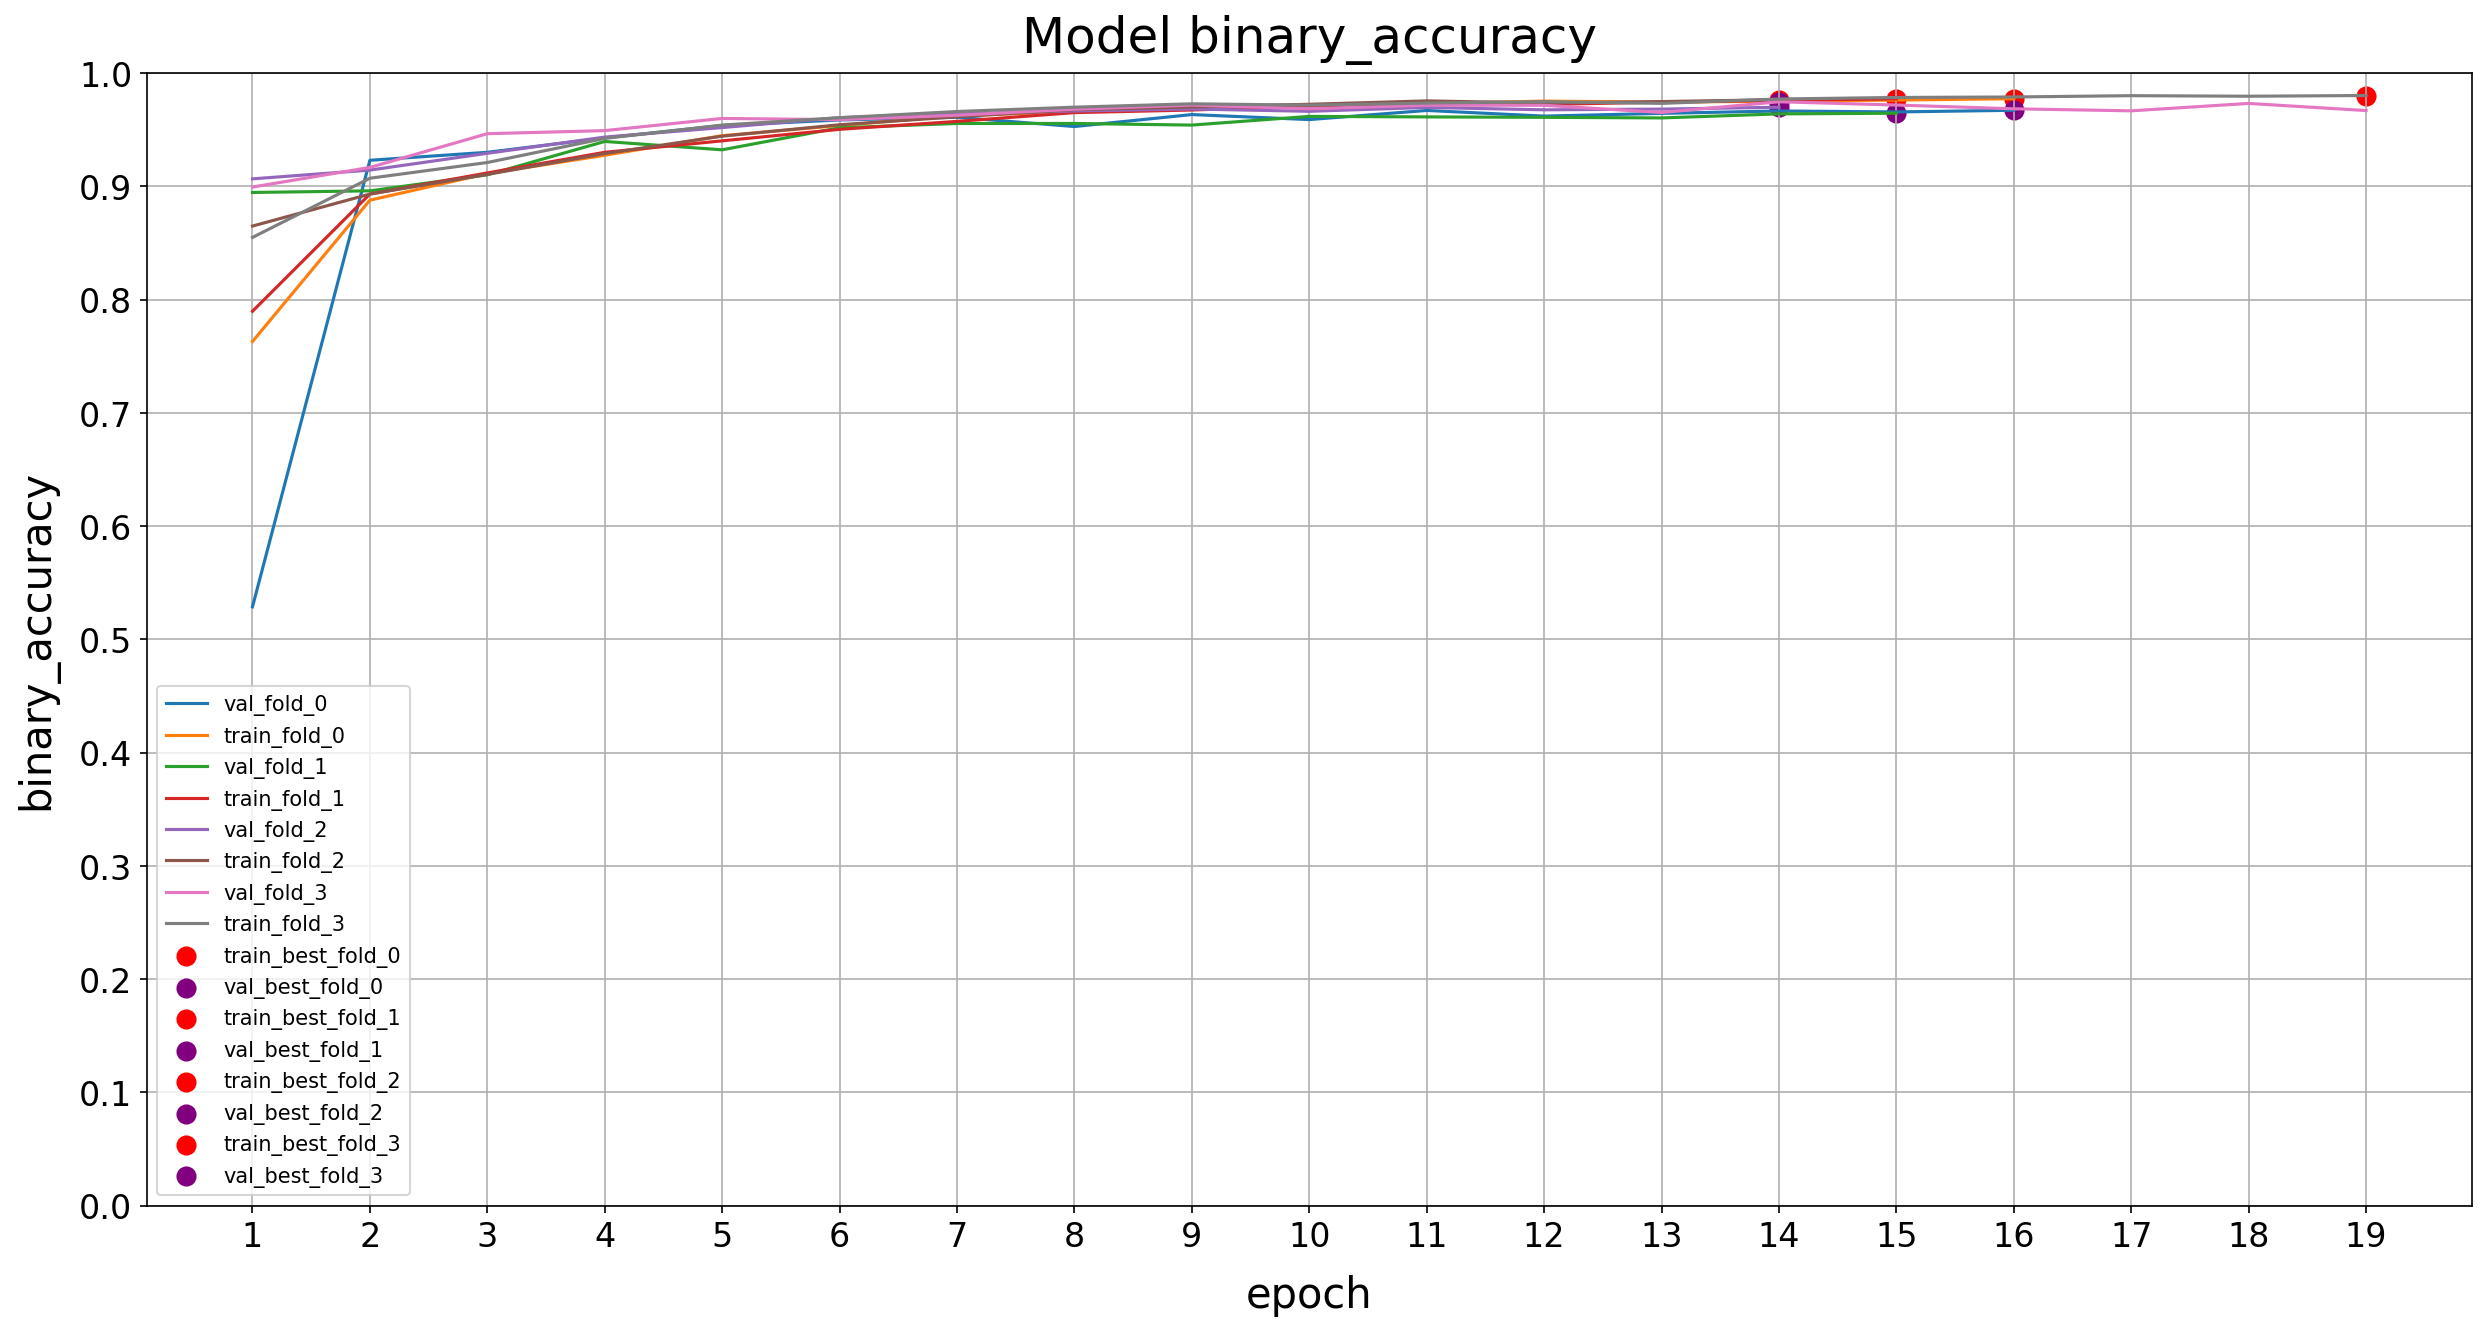

In [64]:
plot_history_metric('binary_accuracy', ylim=(0,1), yticks=np.arange(0, 1.1, 0.1))

# Validation Predictions

In [65]:
def predict_fold(model, val_idxs):
    # Validation Dataset
    dataset = get_dataset(
        tfrecord_idxs=val_idxs,
        bs=len(val_idxs),
        val=True,
        return_organ=True,
        debug=True,
    )

    # Validation images, masks and organs
    val_images, val_masks, val_organs = next(iter(dataset))
    # Cast from Tensorflow to Numpy
    val_images = val_images.numpy()
    val_masks = val_masks.numpy()
    val_organs = val_organs.numpy()
    print(f'val_images shape: {val_images.shape}, val_masks shape: {val_masks.shape}, val_organs shape: {val_organs.shape}')
    
    # Validation Predictions
    val_y_preds = model.predict(val_images, verbose=1, batch_size=len(val_idxs))
    print(f'VAL_Y_PREDS shape: {val_y_preds.shape}, VAL_Y_PREDS dtype: {val_y_preds.dtype}')
    
    return val_images, val_masks, val_organs, val_y_preds

# Mean Intersection Over Union By Threshold

Important analysis on the actual leaderboard metric, intersection over union, in general and per organ at different thresholds. The mean IoU per organ will vary widely, with the lung being by far the hardest to predict with a ~0.10 IoU.

In [66]:
def iou(y_true, y_pred):
    intersection = np.count_nonzero(y_true * y_pred)
    union = np.count_nonzero(y_true + y_pred)
    return intersection / union

In [67]:
# Predictions and true labels of validation dataset
def calculate_y_true_y_pred(model, val_images, val_masks, val_organs, val_y_preds):
    thresholds = np.arange(0, 1.01, 0.01)
    IoUs = {}
    for t in thresholds:
        IoUs[t] = []
        
    IoUsOrgans = {}
    for o in ORGANS:
        IoUsOrgans[o] = {}
        for t in thresholds:
            IoUsOrgans[o][t] = []
    
    for idx, (image, y_true, organ, y_pred) in enumerate(zip(tqdm(val_images), val_masks, val_organs, val_y_preds)):
        if idx == 0:
            print(f'image shape: {image.shape}, y_true shape: {y_true.shape}')
            print(f'organs: {organ.decode()}, y_pred shape: {y_pred.shape}')
        
        # Compute IoU for each threshold
        o = organ.decode()
        for t in thresholds:
            IoU = iou(y_true, (y_pred > t).astype(np.int8))
            IoUs[t].append(IoU)
            IoUsOrgans[o][t].append(IoU)
    
    return IoUs, IoUsOrgans

In [68]:
#PREDICT_FOLDS = [0, 1, 2, 3]
PREDICT_FOLDS = [3]
METRICS = {}
for fold, train_idxs, val_idxs in zip(IDXS['folds'], IDXS['train_idxs'], IDXS['val_idxs']):
    if fold not in PREDICT_FOLDS:
        print("[PREDICT-MODEL] JUMP FOLD", fold)
        continue
    # Pretrained File Path: '/kaggle/input/sartorius-training-dataset/model.h5'
    model_name = F"best_model_{fold}.h5"
    model_path = F"{CHECKPOINTS_DIR}/fold{fold}/{model_name}"
    if not os.path.exists(model_path):
        print("[PREDICT-MODEL] DOESN'T EXISTS", model_name)
        continue
    
    print(F"[PREDICT-MODEL] MODEL: {model_name}, FOLD: {fold}")
    # Load Model
    model = get_model(file_path=model_path, enable_TPU=False)
    
    # Load Dataset
    if fold == 3:
        val_idxs = np.append(1, val_idxs.copy())
    val_images, val_masks, val_organs, val_y_preds = predict_fold(model, val_idxs)
    
    # Calculate Metrics
    IoUs, IoUsOrgans = calculate_y_true_y_pred(model, val_images, val_masks, val_organs, val_y_preds)
    
    #if fold == 3:
    #    IoUs = IoUs[1:]
    #    IoUsOrgans = IoUsOrgans[1:]
    
    metrics = {"IoUs": IoUs, "IoUsOrgans": IoUsOrgans}
    # Save file
    print("[PREDICT-MODEL] Saving fold{fold}")
    with open(f"{PREDICTIONS_DIR}/metrics_fold{fold}.pickle", 'wb') as f:
        pickle.dump(metrics, f) 
        
    METRICS[fold] = metrics

[PREDICT-MODEL] JUMP FOLD 0
[PREDICT-MODEL] JUMP FOLD 1
[PREDICT-MODEL] JUMP FOLD 2
[PREDICT-MODEL] MODEL: best_model_3.h5, FOLD: 3
Loading pretrained weights...
val_images shape: (88, 768, 768, 3), val_masks shape: (88, 768, 768, 1), val_organs shape: (88,)
1/1 [==============================] - 34s 34s/step
VAL_Y_PREDS shape: (88, 768, 768, 1), VAL_Y_PREDS dtype: float32


  0%|          | 0/88 [00:00<?, ?it/s]

image shape: (768, 768, 3), y_true shape: (768, 768, 1)
organs: prostate, y_pred shape: (768, 768, 1)
[PREDICT-MODEL] Saving fold{fold}


In [69]:
def load_metrics():
    metrics = {}
    for fold in range(N_FOLDS):
        print("[PREDICT-MODEL] LOADING fold{fold}")
        with open(f"{PREDICTIONS_DIR}/metrics_fold{fold}.pickle", 'rb') as f:
            metrics[fold] = pickle.load(f)
    
    return metrics

In [70]:
METRICS = load_metrics()
# Check metrics
for fold in range(N_FOLDS):
    if fold not in METRICS:
        print(F"[METRICS] DON'T FIND METRIC IN FOLD {fold}")
        continue
    print("[METRICS] KEYS:", METRICS[fold].keys())

[PREDICT-MODEL] LOADING fold{fold}
[PREDICT-MODEL] LOADING fold{fold}
[PREDICT-MODEL] LOADING fold{fold}
[PREDICT-MODEL] LOADING fold{fold}
[METRICS] KEYS: dict_keys(['IoUs', 'IoUsOrgans'])
[METRICS] KEYS: dict_keys(['IoUs', 'IoUsOrgans'])
[METRICS] KEYS: dict_keys(['IoUs', 'IoUsOrgans'])
[METRICS] KEYS: dict_keys(['IoUs', 'IoUsOrgans'])


# Mean IoU at Threshold

In [71]:
def plot_iou_by_threshold(metrics, mode, organ=None):
    plt.figure(figsize=(12,8))
    name = mode if mode == "all" else organ
    plt.title(f'Mean IoU by Threshold {name}', size=24)
    plt.grid()
    plt.xlabel('Threshold', size=16)
    plt.ylabel('Mean IoU', size=16)
    best_thresholds = {}
    for fold, fold_metric in metrics.items():
        #print(fold_metric.keys())
        if mode == "all":
            ious = fold_metric["IoUs"]
            name = mode
        else:
            ious = fold_metric["IoUsOrgans"][organ]
            name = organ
            
        thresholds = list(ious.keys())
        MeanIoUs = [np.mean(v)for v in ious.values()]

        
        
        plt.plot(thresholds, MeanIoUs)
       
        plt.xticks(size=12)
        plt.yticks(size=12)
        plt.ylim(0,1)

        # Best Threshold
        arg_best = np.argmax(MeanIoUs)
        threshold_best = thresholds[arg_best]
        best_thresholds[fold] = threshold_best
        mean_iou_best = MeanIoUs[arg_best]
        plt.scatter(threshold_best, mean_iou_best, s=100, marker='o', 
                    label=f'Fold{fold}: Best Mean IoU ({mean_iou_best:.3f}) at Threshold {threshold_best:.3f}')
        plt.legend(prop={'size': 16})

    plt.show()
    
    return best_thresholds

In [72]:
THRESHOLDS = {"all": {}, "organs": {}}

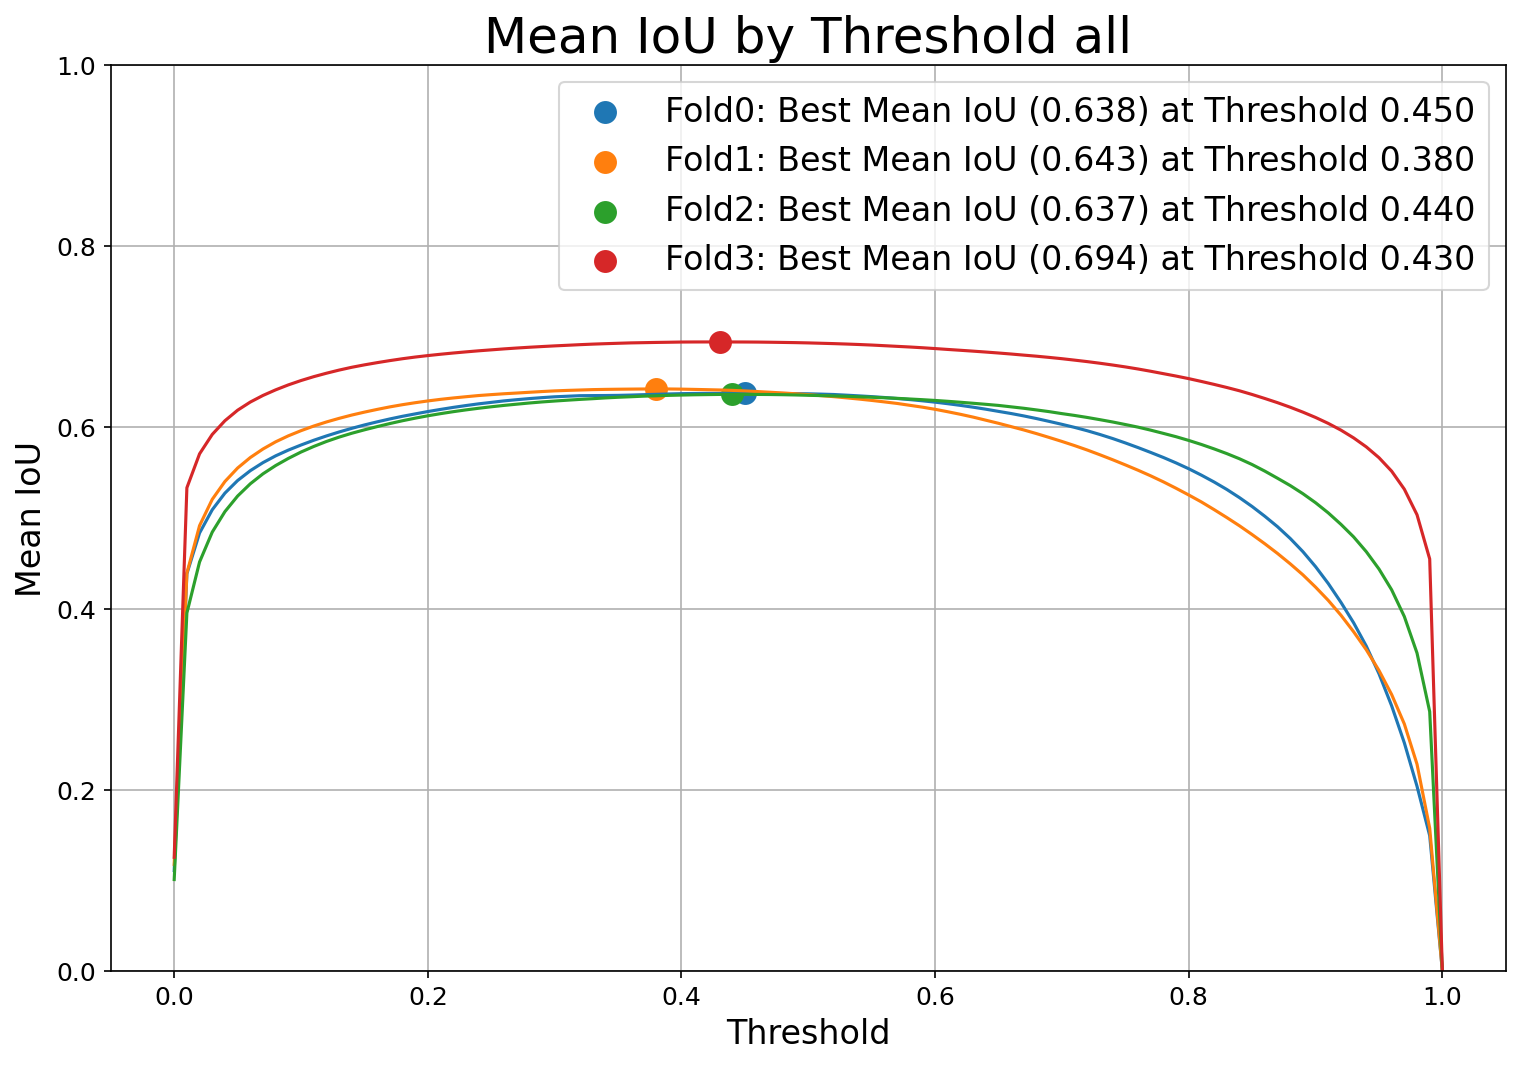

In [73]:
# Global Mean Intersection over Union at Threshold
#threshold_best = plot_iou_by_threshold(IoUs, 'All')
THRESHOLDS["all"]  = plot_iou_by_threshold(METRICS, 'all')

In [74]:
THRESHOLDS

{'all': {0: 0.45, 1: 0.38, 2: 0.44, 3: 0.43}, 'organs': {}}

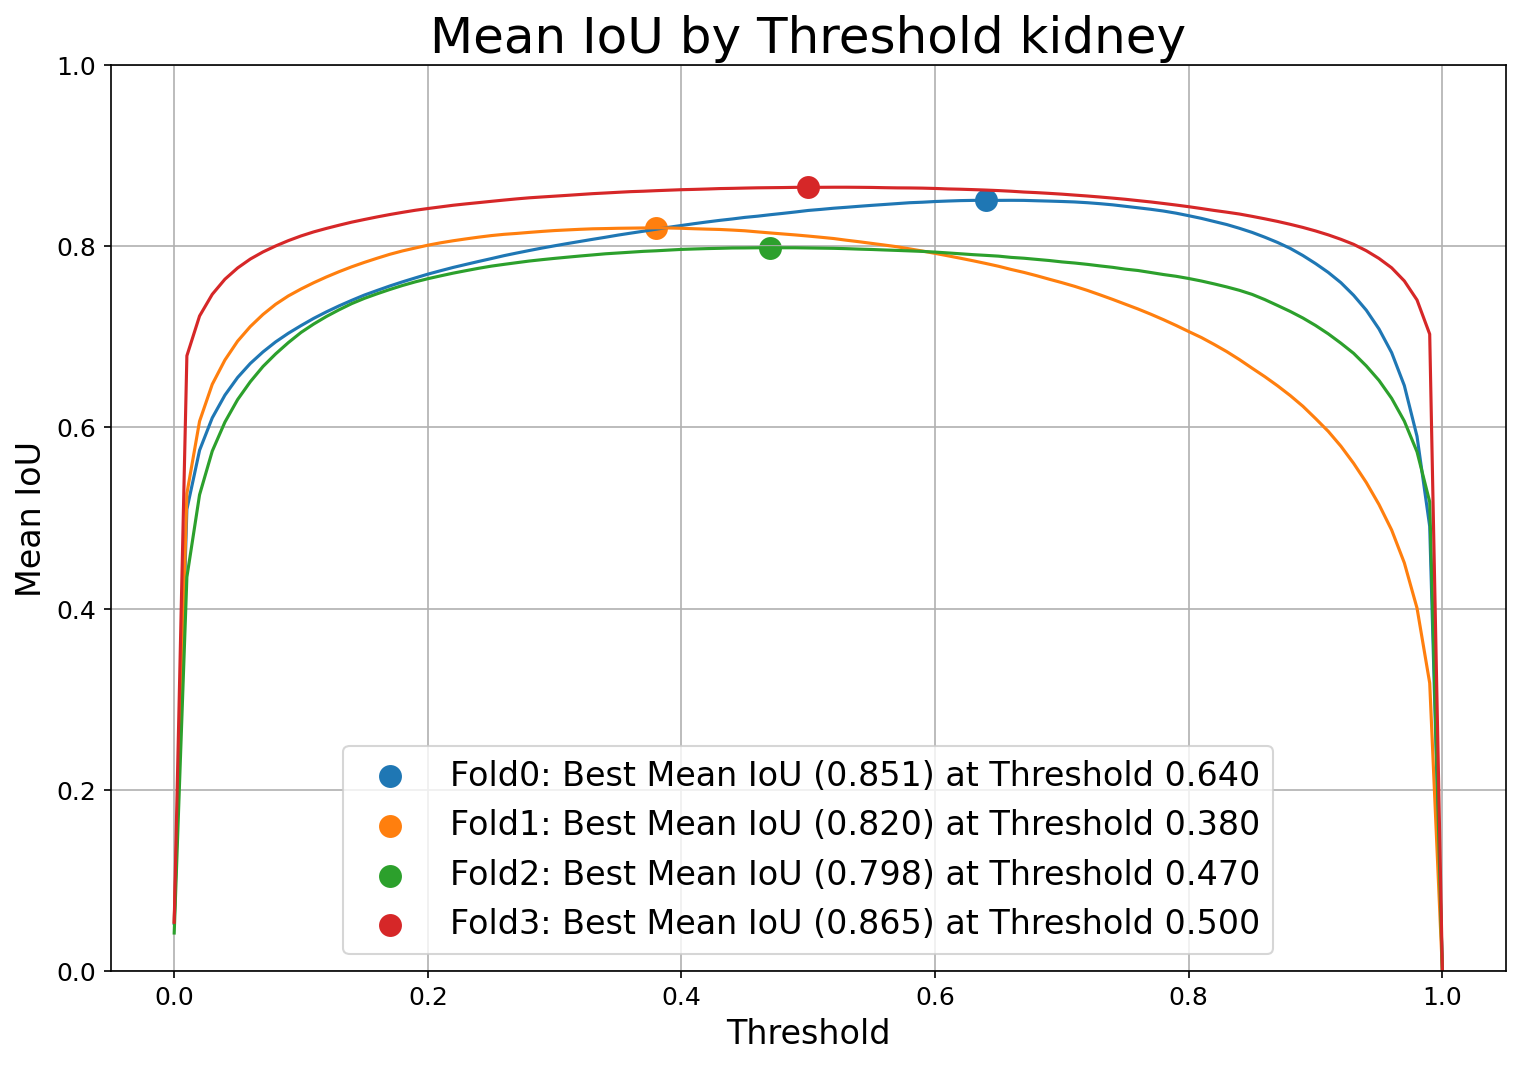

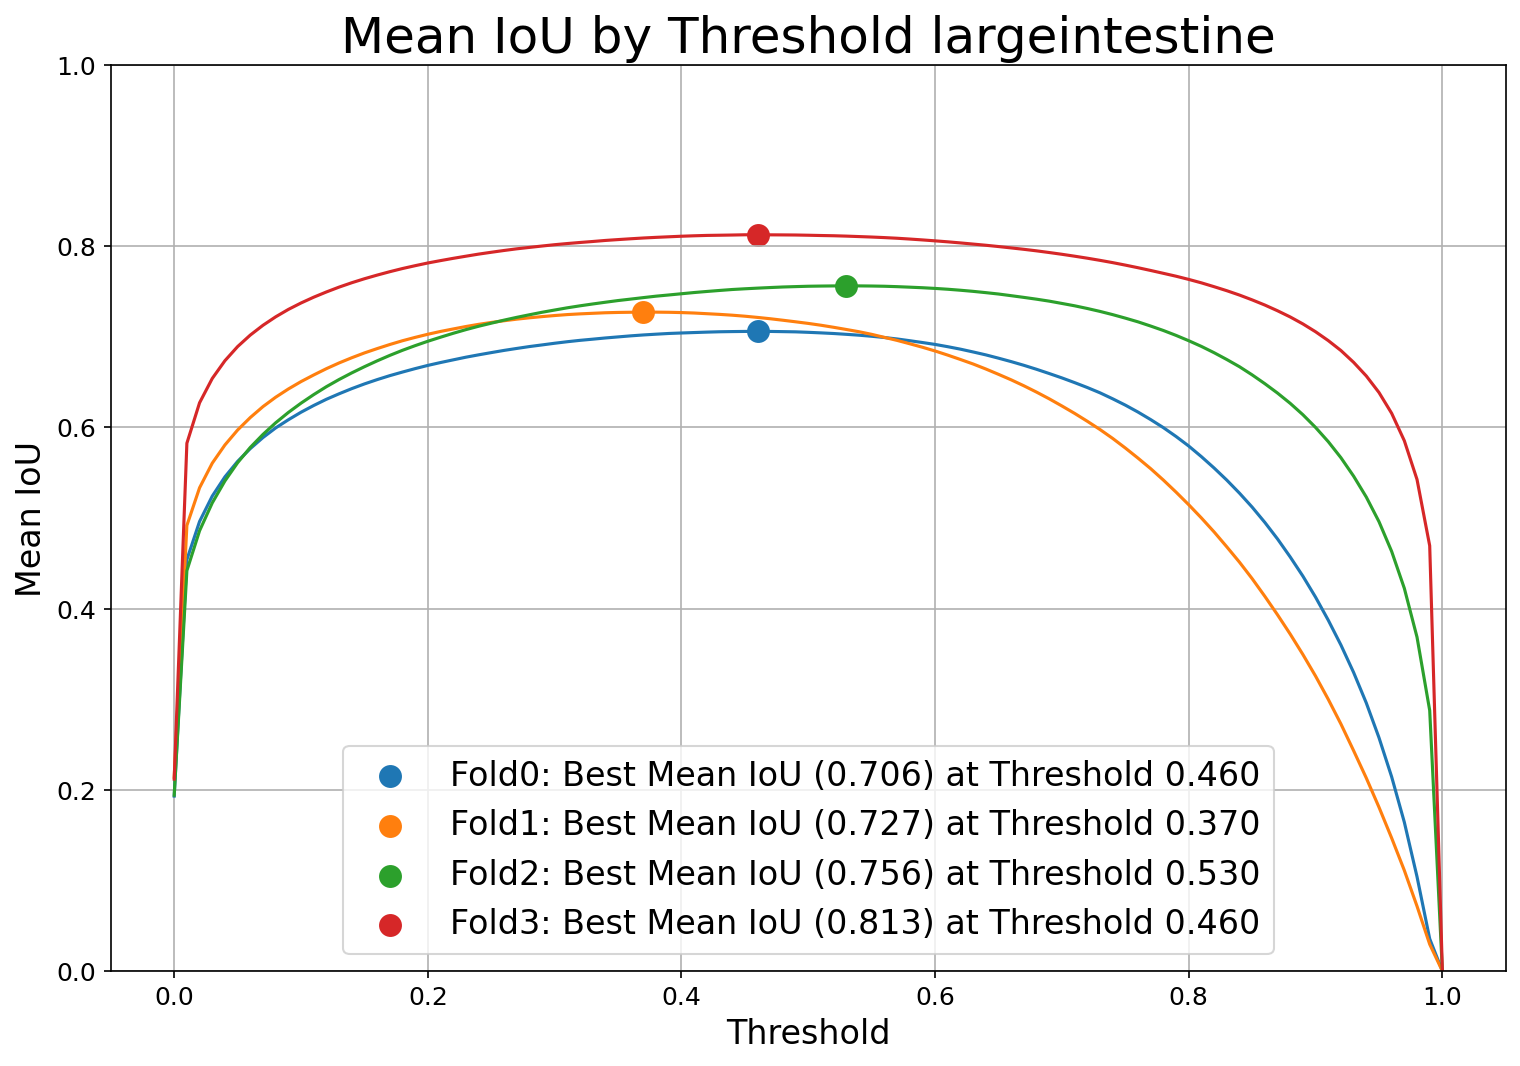

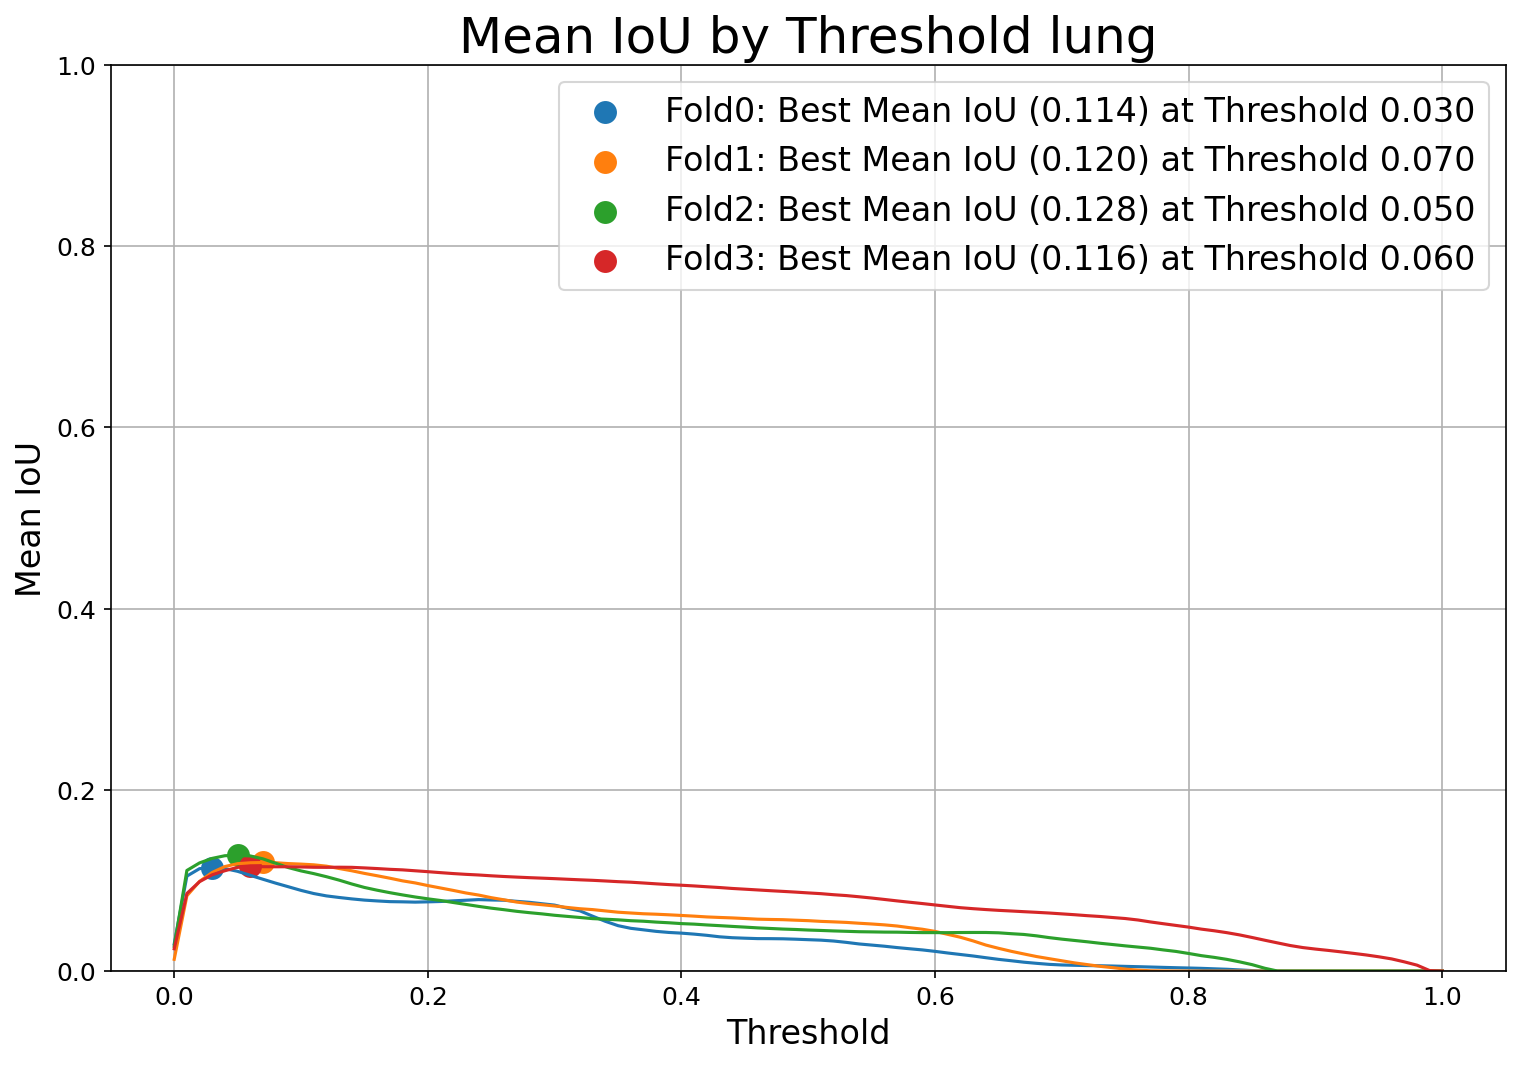

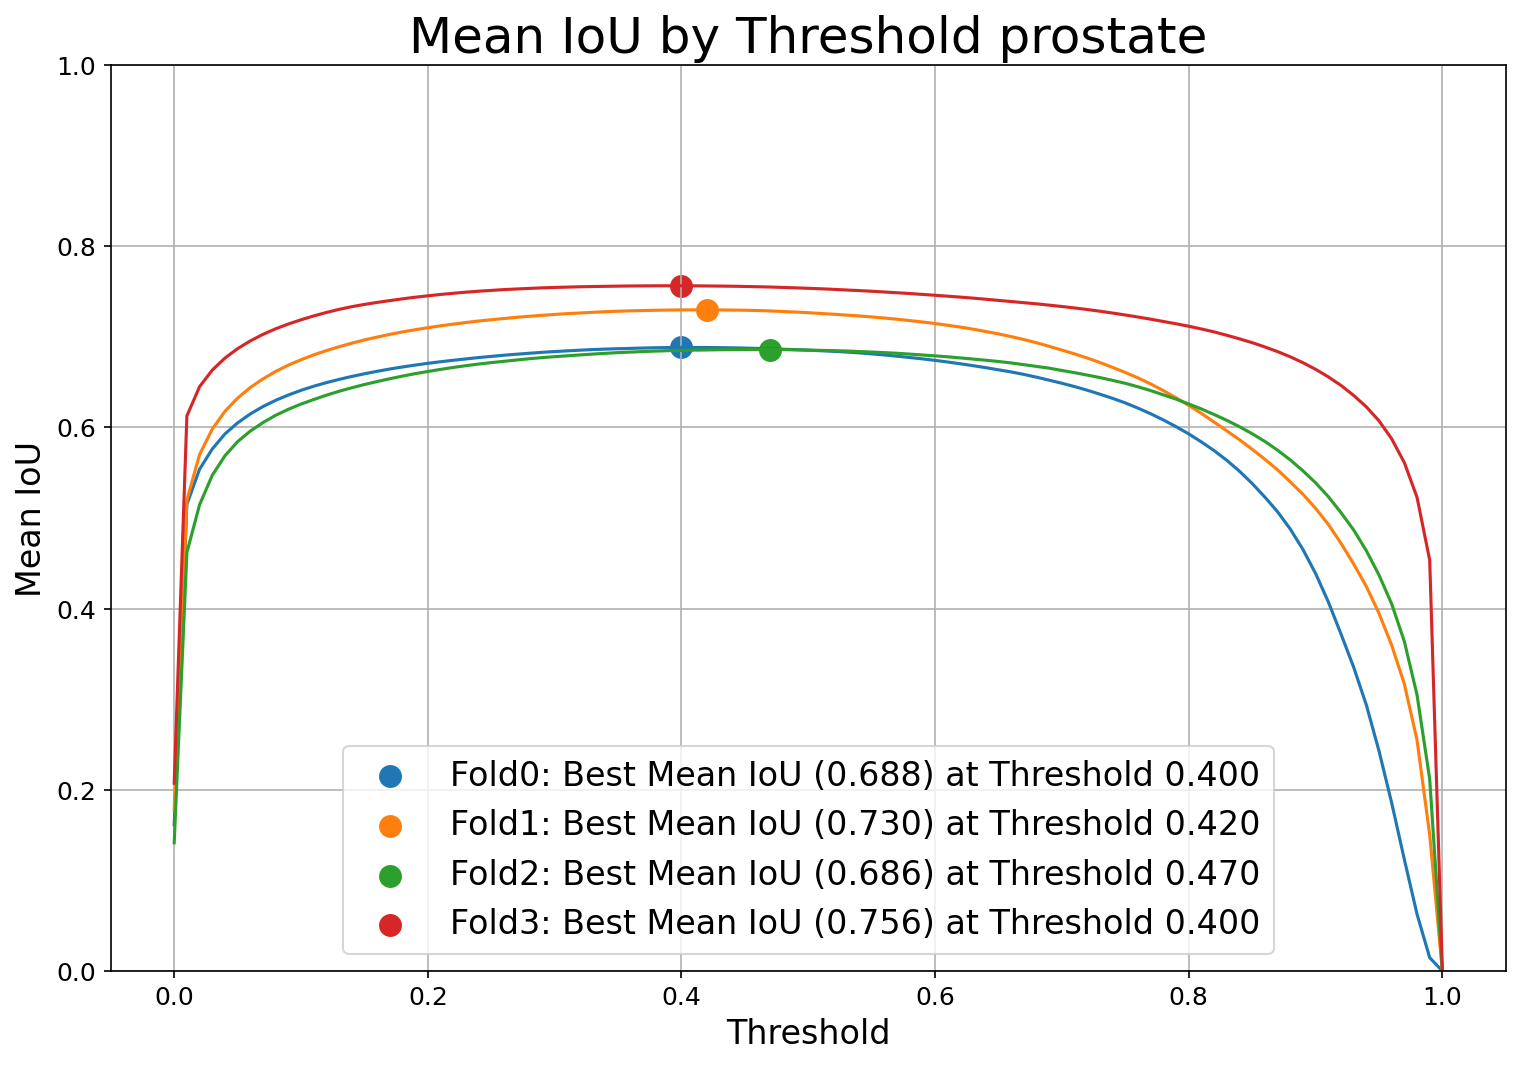

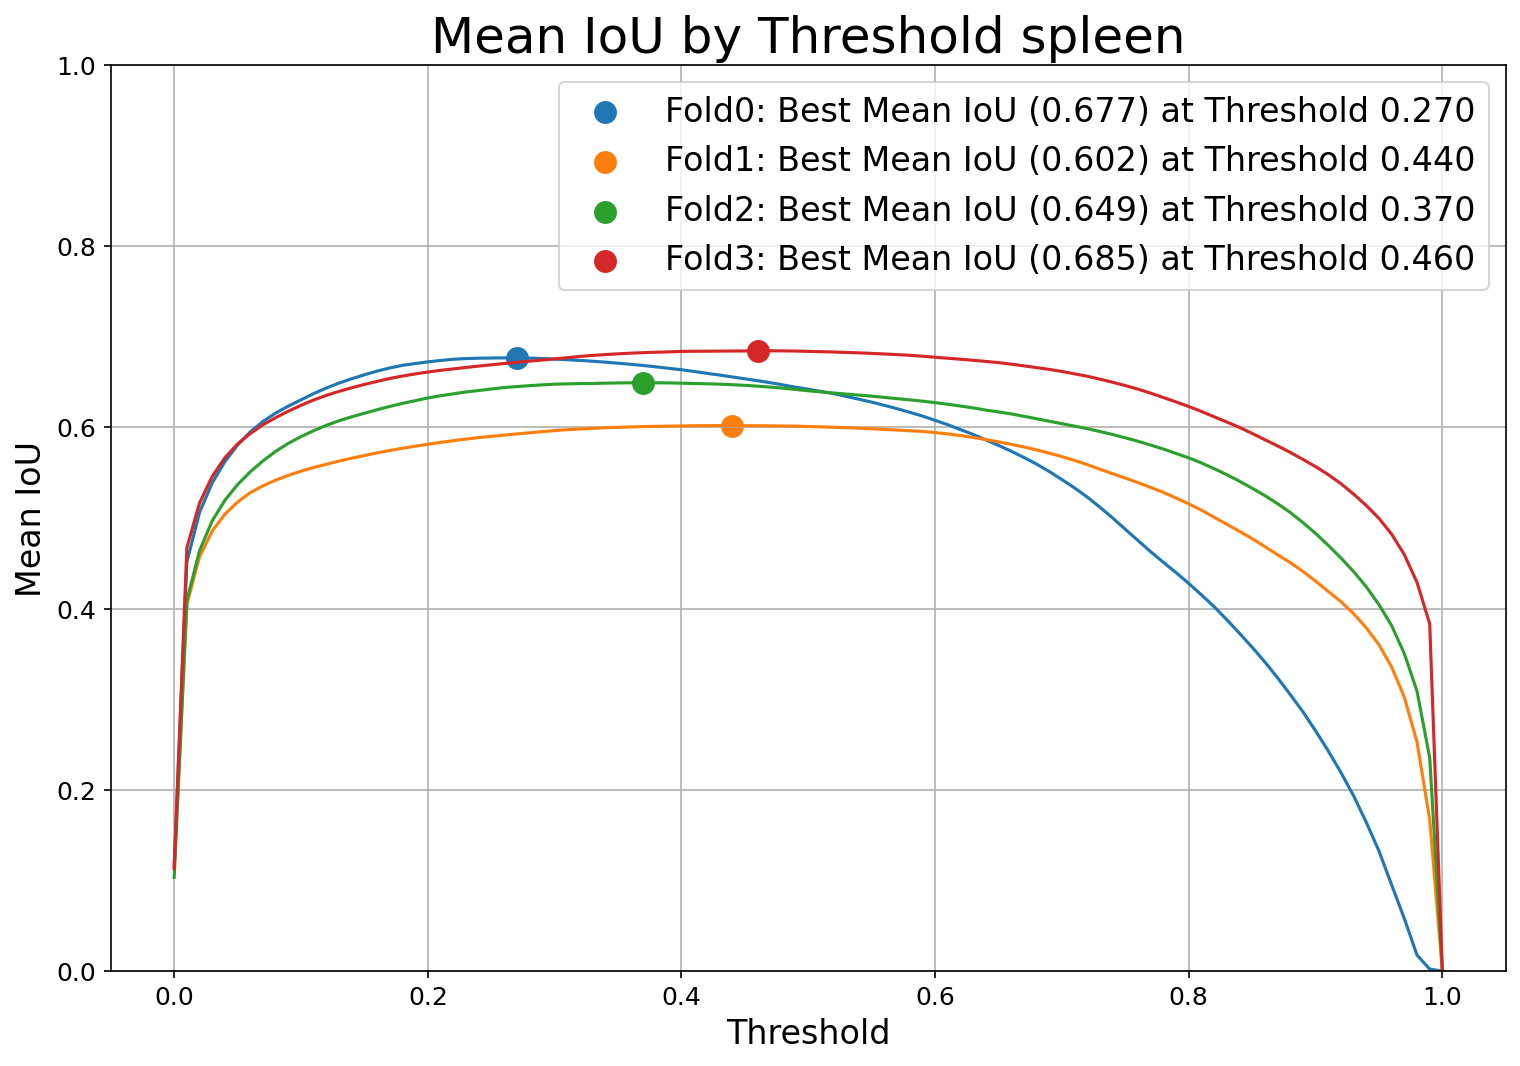

In [75]:
# Per Organ Mean Intersection over Union at Threshold
for organ, ious in IoUsOrgans.items():
    #plot_iou_by_threshold(ious, organ)
    THRESHOLDS["organs"][organ] = plot_iou_by_threshold(METRICS, 'organ', organ)

In [76]:
THRESHOLDS["all"], THRESHOLDS["organs"]["lung"]

({0: 0.45, 1: 0.38, 2: 0.44, 3: 0.43}, {0: 0.03, 1: 0.07, 2: 0.05, 3: 0.06})

In [77]:
with open(f"{PREDICTIONS_DIR}/best_predictions.pickle", 'wb') as f:
    pickle.dump(THRESHOLDS, f) 

In [78]:
!ls -lh predictions
!rm predictions.zip
!zip -r predictions.zip predictions/*

total 724K
-rw-r--r-- 1 root root  805 Sep 21 18:27 best_predictions.pickle
-rw-r--r-- 1 root root 179K Sep 21 17:54 metrics_fold0.pickle
-rw-r--r-- 1 root root 179K Sep 21 17:54 metrics_fold1.pickle
-rw-r--r-- 1 root root 179K Sep 21 17:54 metrics_fold2.pickle
-rw-r--r-- 1 root root 179K Sep 21 18:27 metrics_fold3.pickle
rm: cannot remove 'predictions.zip': No such file or directory
  adding: predictions/best_predictions.pickle (deflated 35%)
  adding: predictions/metrics_fold0.pickle (deflated 25%)
  adding: predictions/metrics_fold1.pickle (deflated 25%)
  adding: predictions/metrics_fold2.pickle (deflated 26%)
  adding: predictions/metrics_fold3.pickle (deflated 24%)


In [79]:
with open(f"{PREDICTIONS_DIR}/best_predictions.pickle", 'rb') as f:
    THRESHOLDS_2 = pickle.load(f)
THRESHOLDS_2.keys(), THRESHOLDS_2["organs"]["lung"].keys()

(dict_keys(['all', 'organs']), dict_keys([0, 1, 2, 3]))

# IoU Distribution Best Threshold

In [80]:
THRESHOLDS["all"]

{0: 0.45, 1: 0.38, 2: 0.44, 3: 0.43}

In [81]:
#display(pd.Series(IoUs[threshold_best]).describe().apply(lambda v: f'{v:.2f}').to_frame(name='Value'))

In [82]:
#plt.figure(figsize=(12,8))
#pd.Series(IoUs[threshold_best]).plot(kind='hist')
#plt.title('IoU Distribution at Best Threshold', size=24)
#plt.grid()
#plt.xlabel('Threshold', size=16)
#plt.ylabel('Count', size=16)
#plt.xticks(size=12)
#plt.yticks(size=12)
#plt.xlim(0,1)
#plt.show()

# Validation Prediction Visualization

Visualize all validation predictions with the following color codes:

* **RED** False Positive: model predicted pixel to belong to mask but the pixel is actually a background pixel

* **BLUE** False Negative: model predicted pixel to be background but it actually is a pixel belonging to the mask

* **GREEN** True Positive: model predicted the pixel to belong to the mask, and it actually is a mask belonging to the mask!

In [83]:
gc.collect()

31172

In [84]:
def merge_patches(patches):
    if len(patches.shape) == 3:
        return patches
    
    image = np.zeros(shape=[IMG_SIZE_FULL, IMG_SIZE_FULL, patches.shape[-1]], dtype=patches.dtype)
    s = int(N_PATCHES_PER_IMAGE ** 0.50)
    for r in range(s):
        for c in range(s):
            start_x = r * IMG_SIZE
            end_x = (r + 1) * IMG_SIZE
            start_y = c * IMG_SIZE
            end_y = (c + 1) * IMG_SIZE
            image[start_x:end_x, start_y:end_y] = patches[r * s + c]
            
    return image

In [85]:
def plot_validation_predictions():
    for idx, (image, y_true, organ, y_pred) in enumerate(zip(tqdm(val_images), val_masks, val_organs, VAL_Y_PREDS)):
        organ = organ.decode()
        # Predicted Mask
        y_pred = merge_patches(y_pred)
        y_pred_binary = (y_pred > threshold_best).astype(np.uint8)
        # Merge Image and Label patches
        image = merge_patches(image)
        y_true = merge_patches(y_true)
        # Red = False Positive
        r = ((y_pred_binary == 1) * (y_true == 0)).astype(np.uint8) 
        # Green = True Positive
        g = ((y_pred_binary == 1) * (y_true == 1)).astype(np.uint8)
        # Blue = False Negative
        b = ((y_pred_binary == 0) * (y_true == 1)).astype(np.uint8)
        # Error Visualization Using RGB
        mask_error = np.stack((r, g, b), axis=2).squeeze() * 255

        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        axes[0].imshow(image)
        axes[0].set_title(f'Image {organ} IoU: {IoUs[threshold_best][idx]:.2f}')
        axes[1].imshow(y_true)
        axes[1].set_title('Mask True')
        axes[2].imshow(y_pred)
        axes[2].set_title('Mask Pred')
        axes[3].imshow(y_pred_binary)
        axes[3].set_title('Mask Pred Binary')
        axes[4].imshow(mask_error)
        axes[4].set_title('Mask Error')
        
        plt.show()

In [86]:
gc.collect()
#plot_validation_predictions()

21